In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

weather_df = pd.read_csv("3485342.csv")


#preprocessing

#dropping useless columns
weather_df = weather_df.drop(columns=['STATION'])
weather_df = weather_df.drop(columns=['WT16'])
weather_df = weather_df.drop(columns=['PRCP'])

#removing NaN entries
tmax_mask = weather_df['TMAX'].isna()
weather_df = weather_df.loc[tmax_mask == False]

tmin_mask = weather_df['TMIN'].isna()
weather_df = weather_df.loc[tmin_mask == False]

#taking the last 645 entries only (the tail after the gap)
weather_df=weather_df.tail(645)

weather_df.tail()

DATE  TMAX  TMIN
41878  2023-10-05  35.0  17.8
41879  2023-10-06  35.0  17.8
41880  2023-10-07  34.4  17.8
41881  2023-10-08  29.4  15.0
41882  2023-10-09  23.9  15.6

Generating new unseen dates to predict  
Estimated effective range of the model is 3 months

In [2]:
#Last date: October 9 + 3 months => January 9
new = pd.date_range('2022-01-01','2024-01-09', freq='1D')
new=new.astype('string')

#Transformation to np array for efficiency
new=np.asarray(new)

#transformation to numpy datetime
for i in range(len(new)):
        new[i]=np.datetime64(new[i])

#reshape into the only accepted form
new=new.reshape(-1, 1)

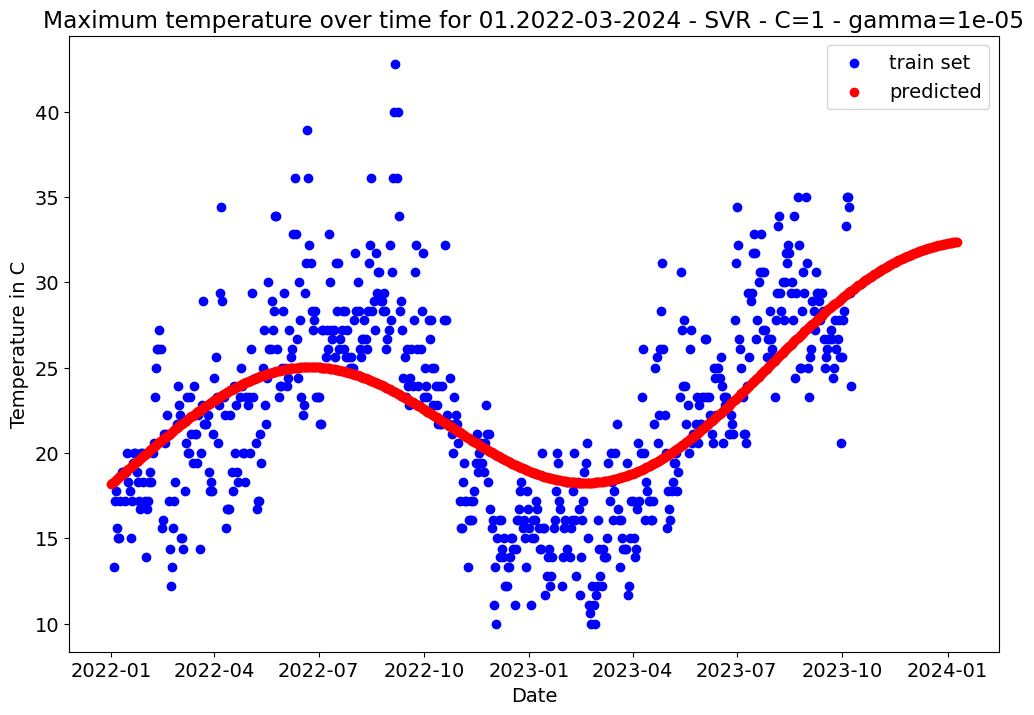

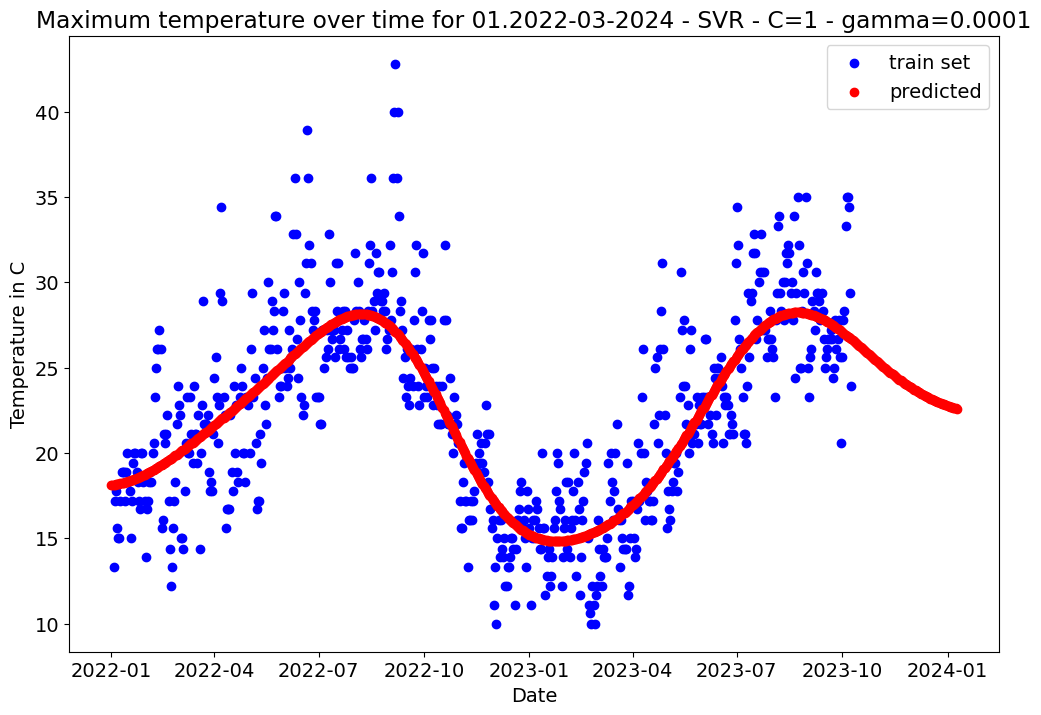

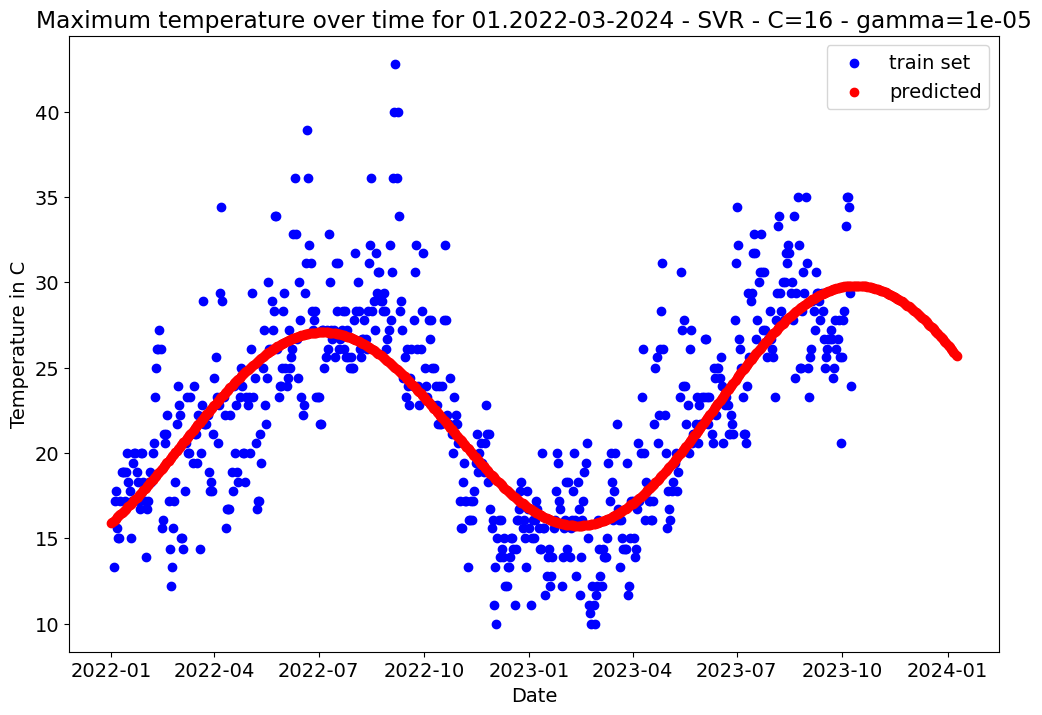

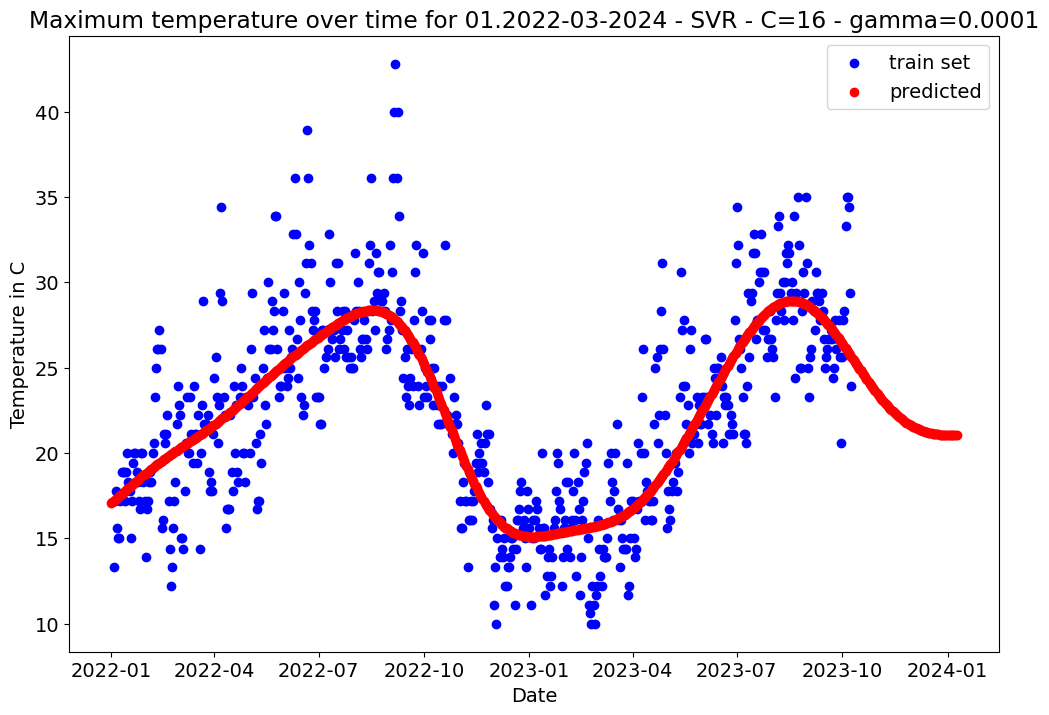

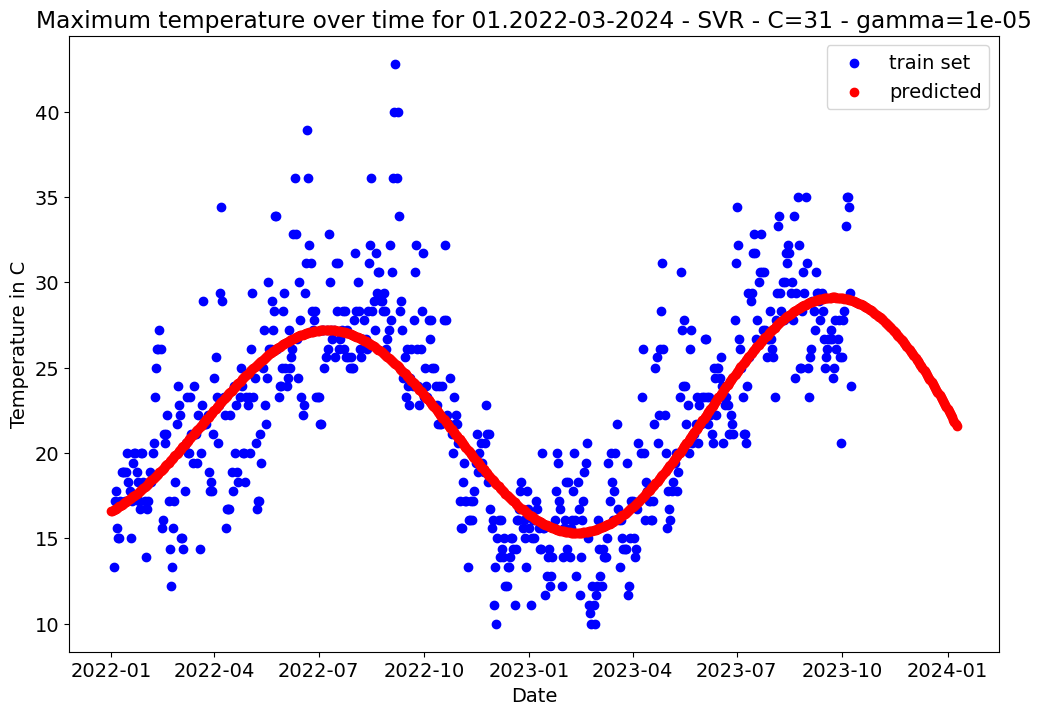

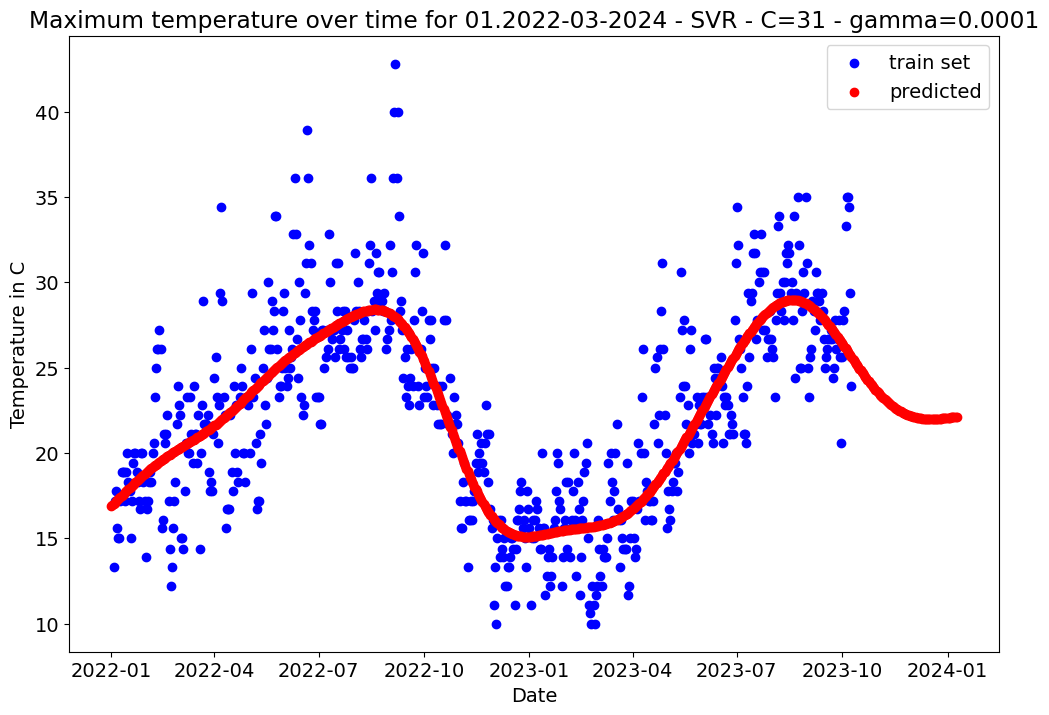

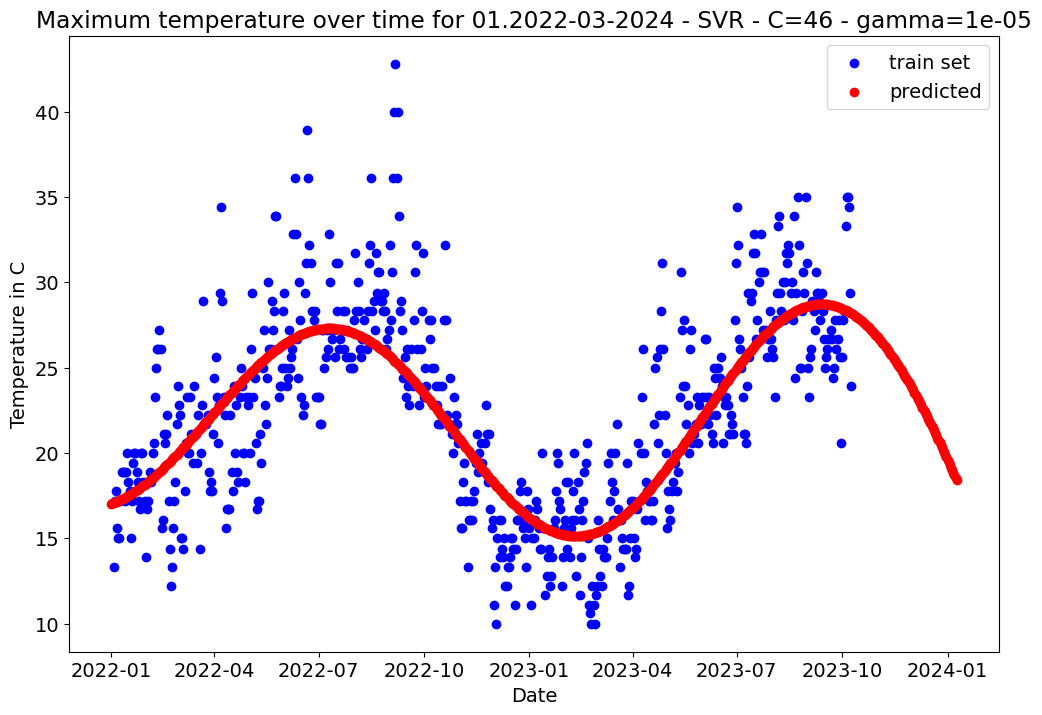

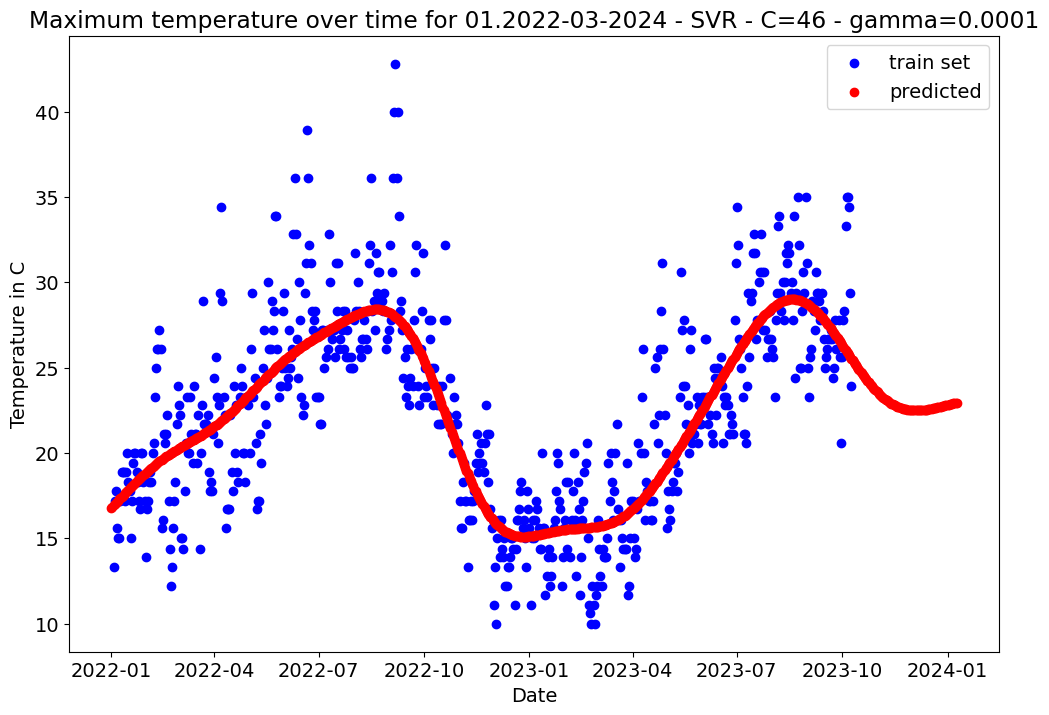

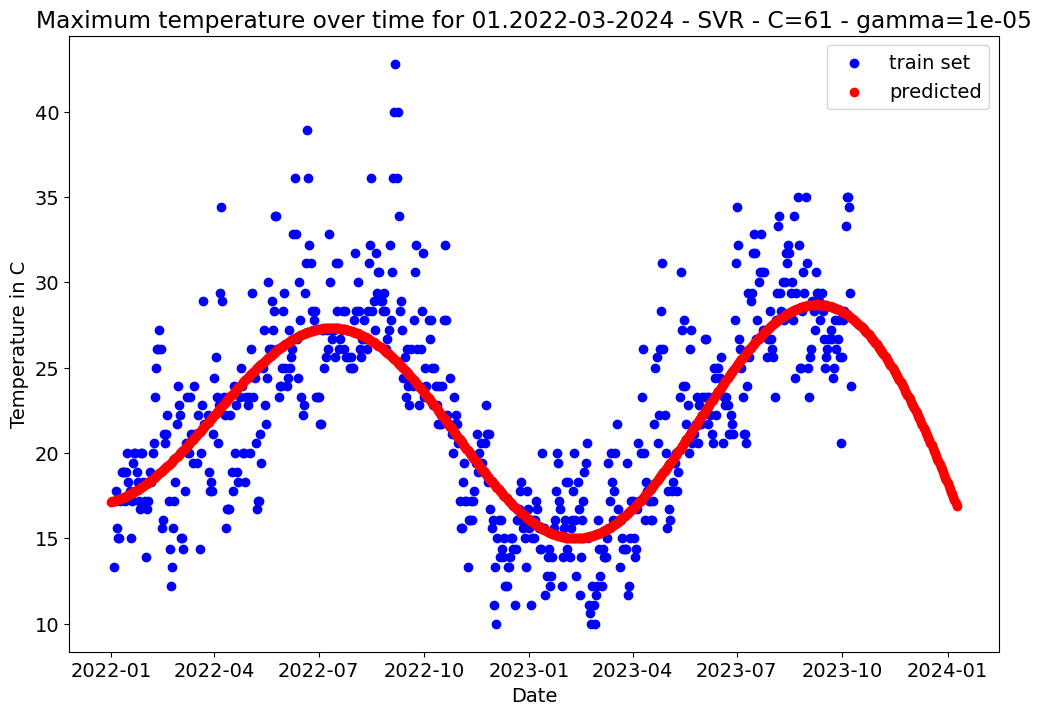

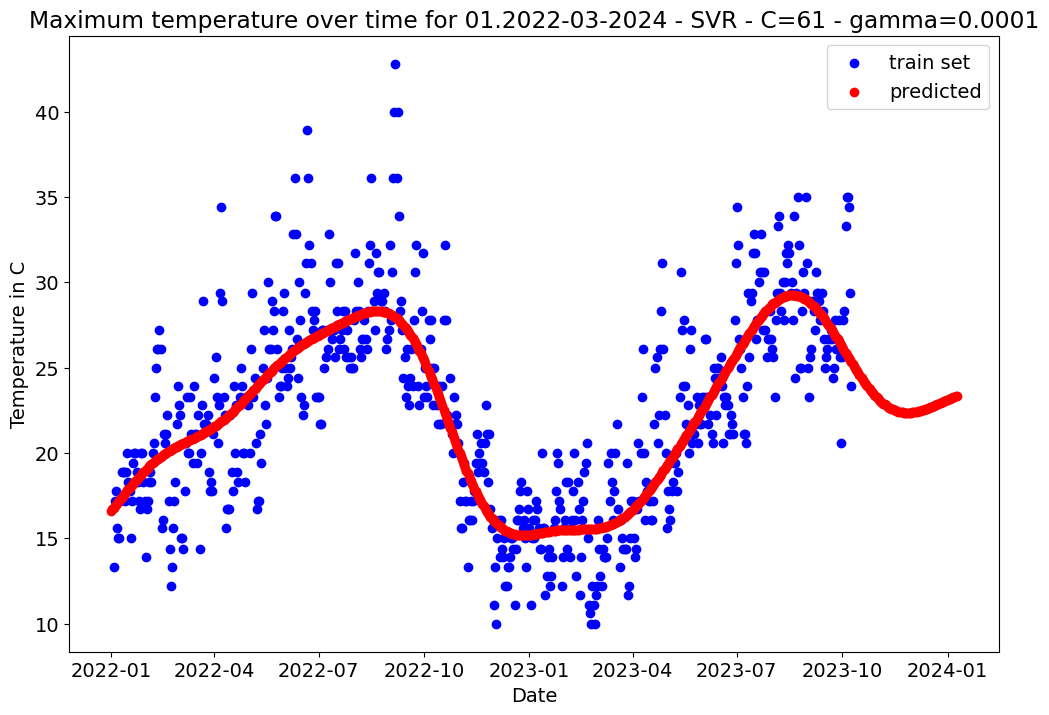

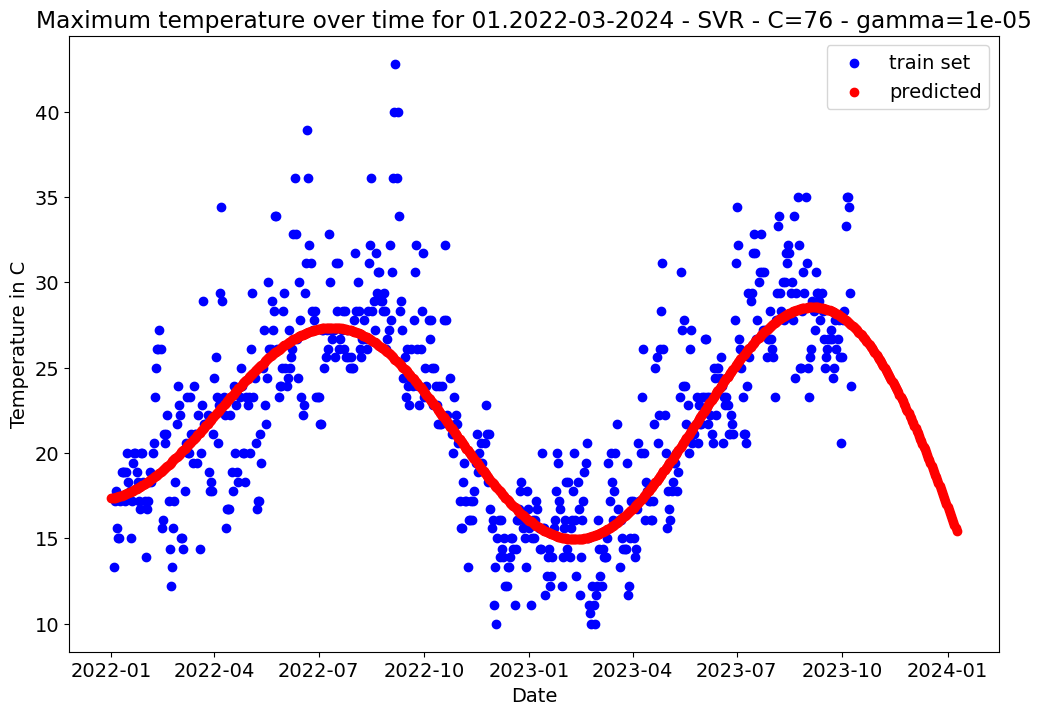

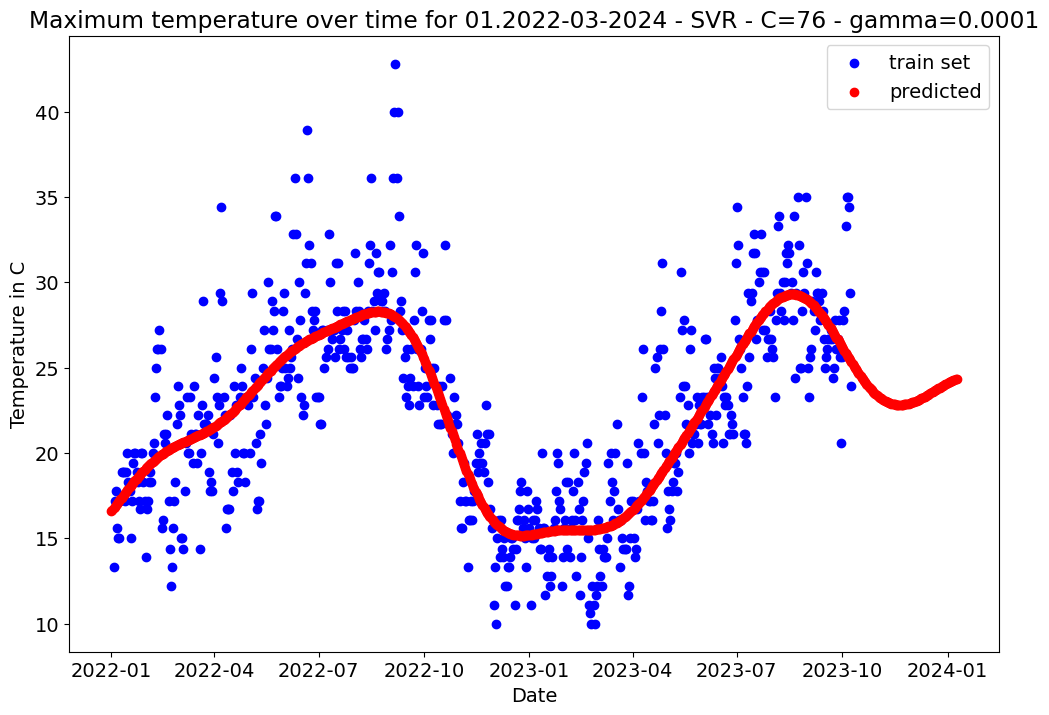

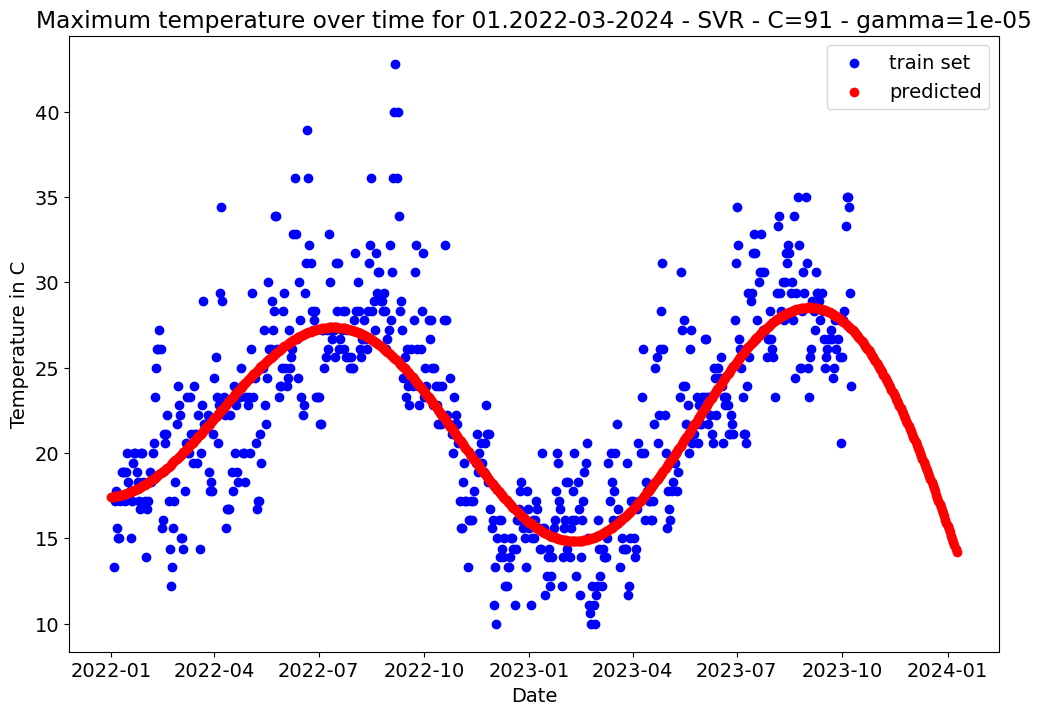

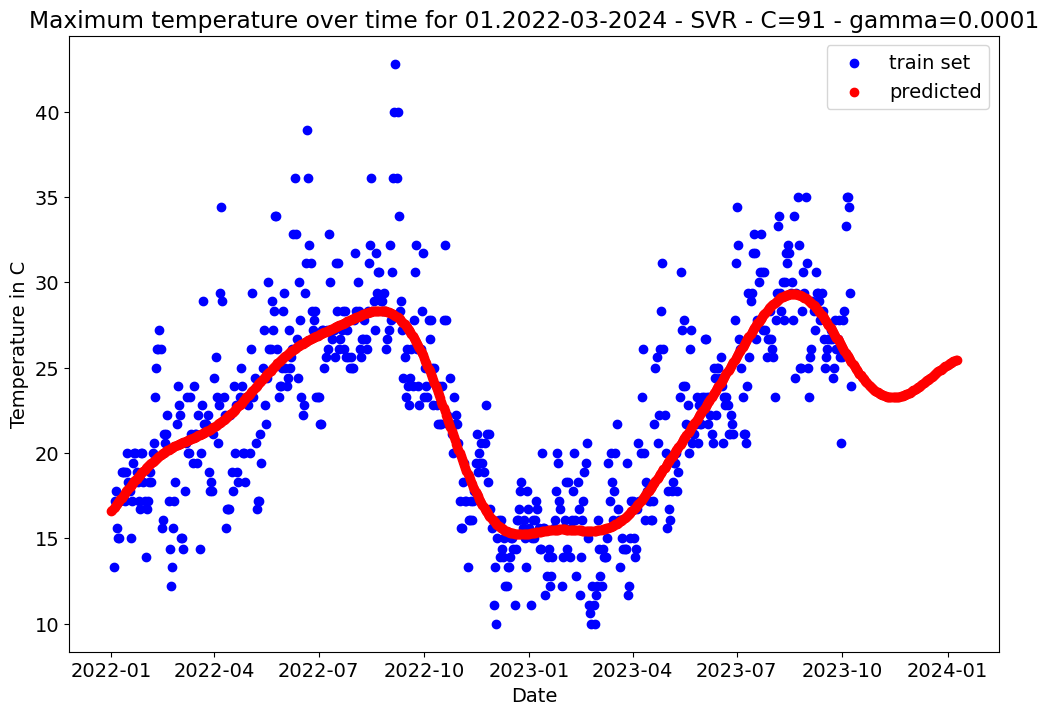

In [3]:
#Populating tmax X and y
tmax_X=np.asarray(weather_df['DATE'].astype('string'))
tmax_y=np.asarray(weather_df['TMAX'])

#Same transformations
for i in range(len(tmax_X)):
    tmax_X[i]=np.datetime64(tmax_X[i])
    
tmax_X=tmax_X.reshape(-1, 1)

#2 best gammas to consider
g=[1.e-5, 1.e-4]

#Iterations by 15 to see get a general direction
for j in range(1,101,15):

        for k in g:
            svr_tmax=SVR(kernel='rbf', C=j, gamma=k)

            svr_tmax.fit(tmax_X, tmax_y)

            tmax_pred=svr_tmax.predict(new)

            plt.title(f"Maximum temperature over time for 01.2022-03-2024 - SVR - C={j} - gamma={k}")
            plt.scatter(tmax_X,tmax_y, color="blue")
            plt.scatter(new, tmax_pred, color="red")
            plt.xlabel("Date")
            plt.ylabel("Temperature in C")
            plt.legend(['train set','predicted'])
            plt.plot()
            plt.show()

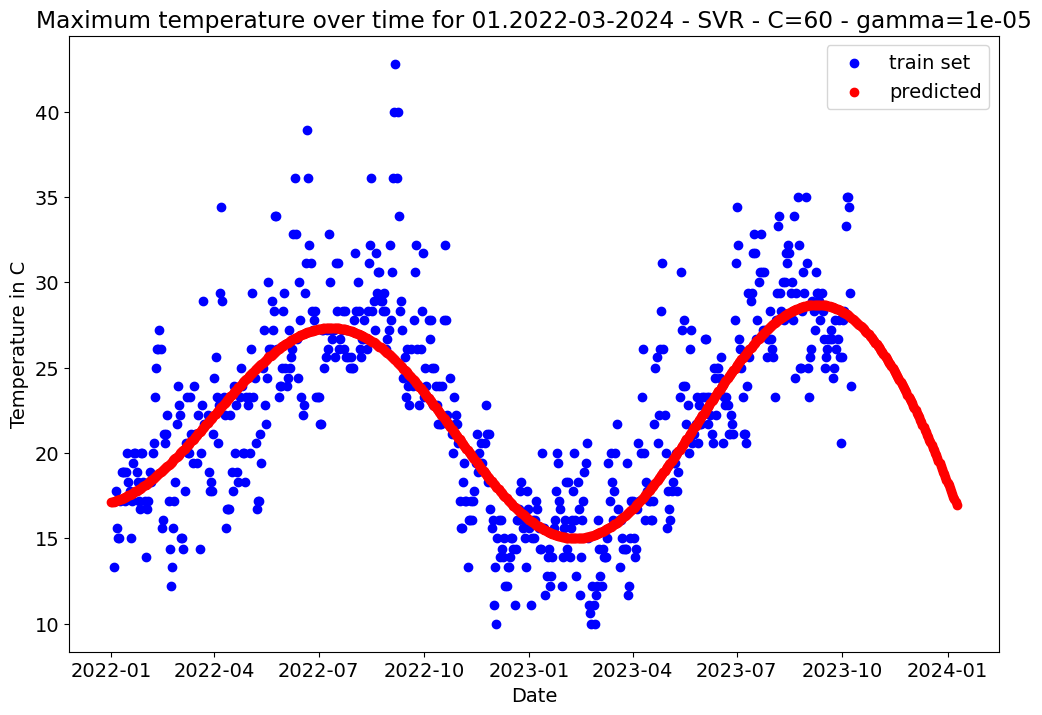

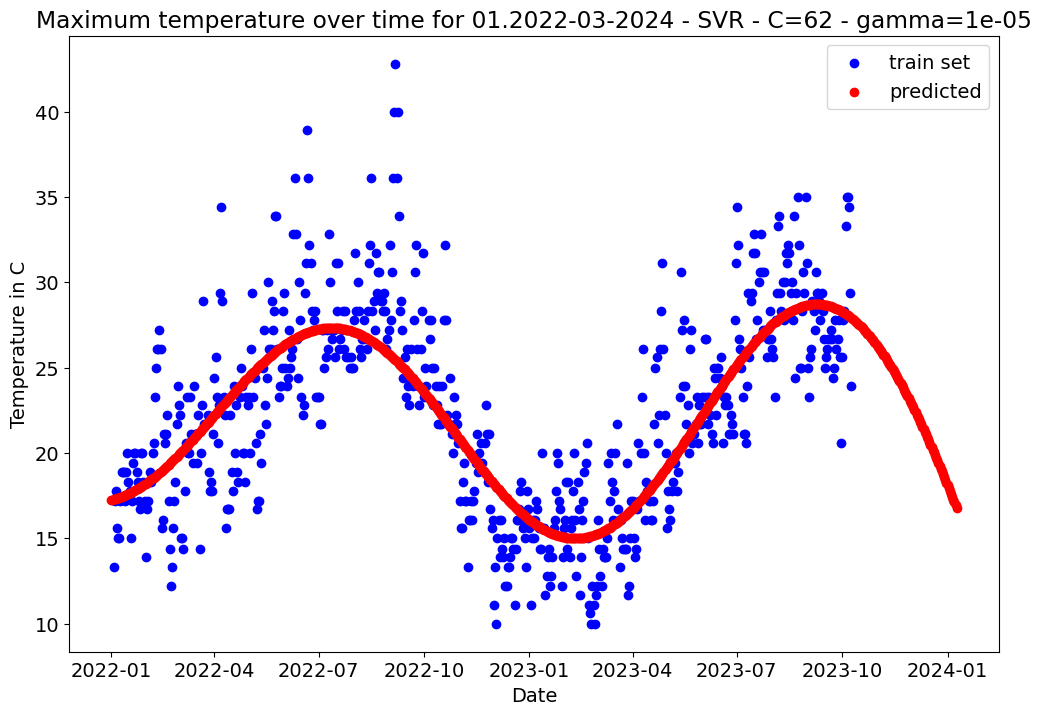

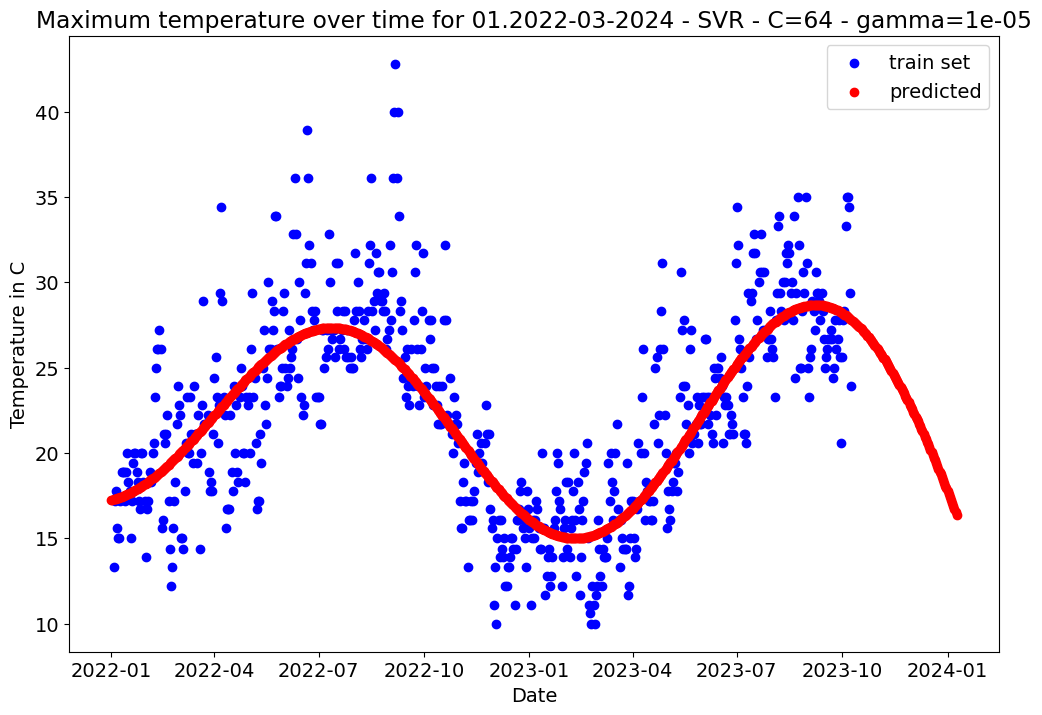

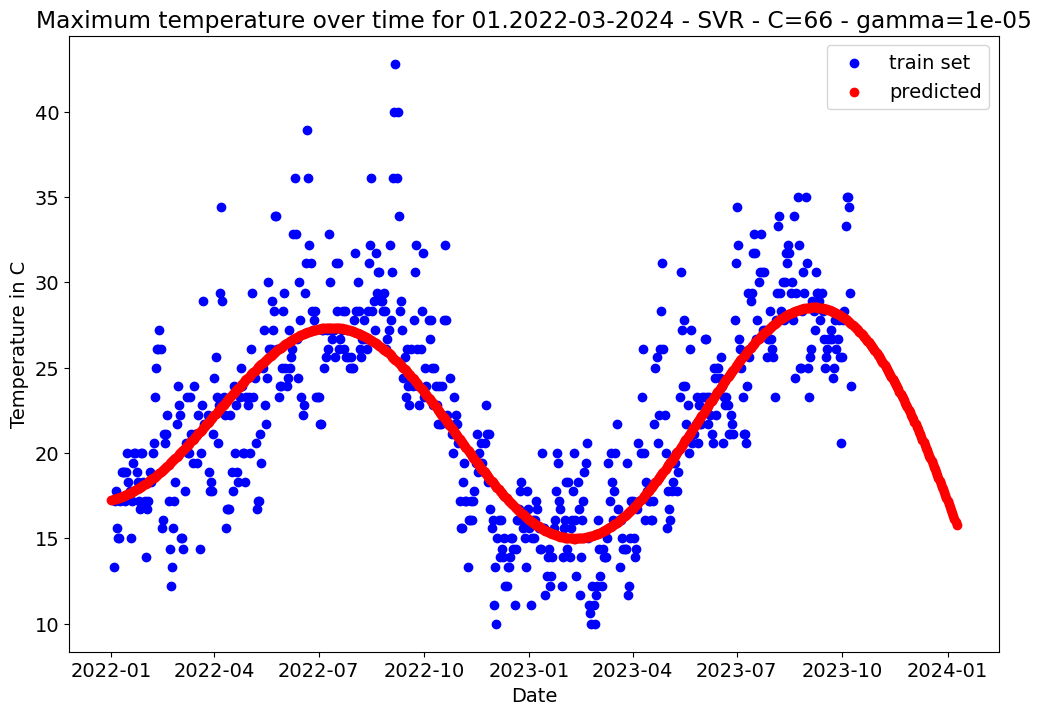

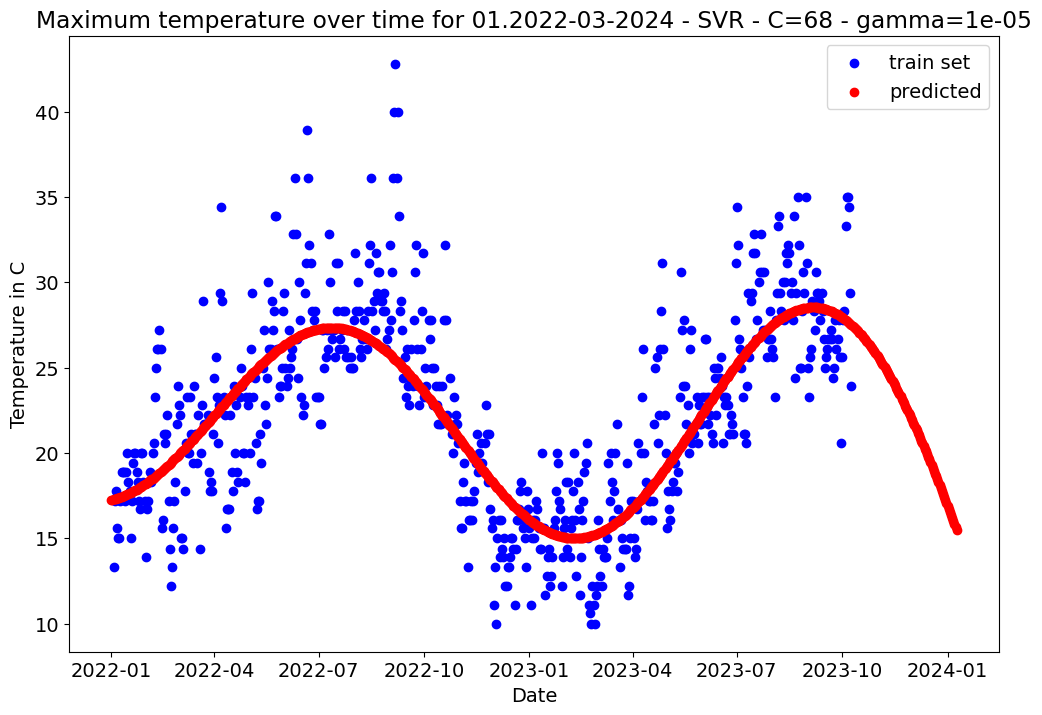

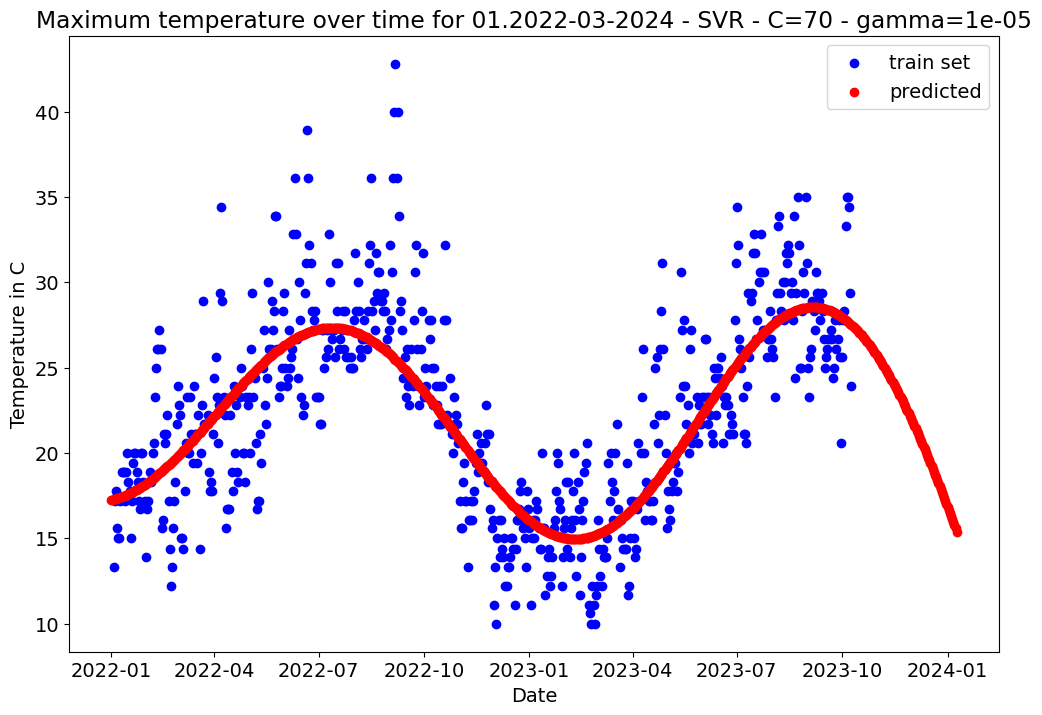

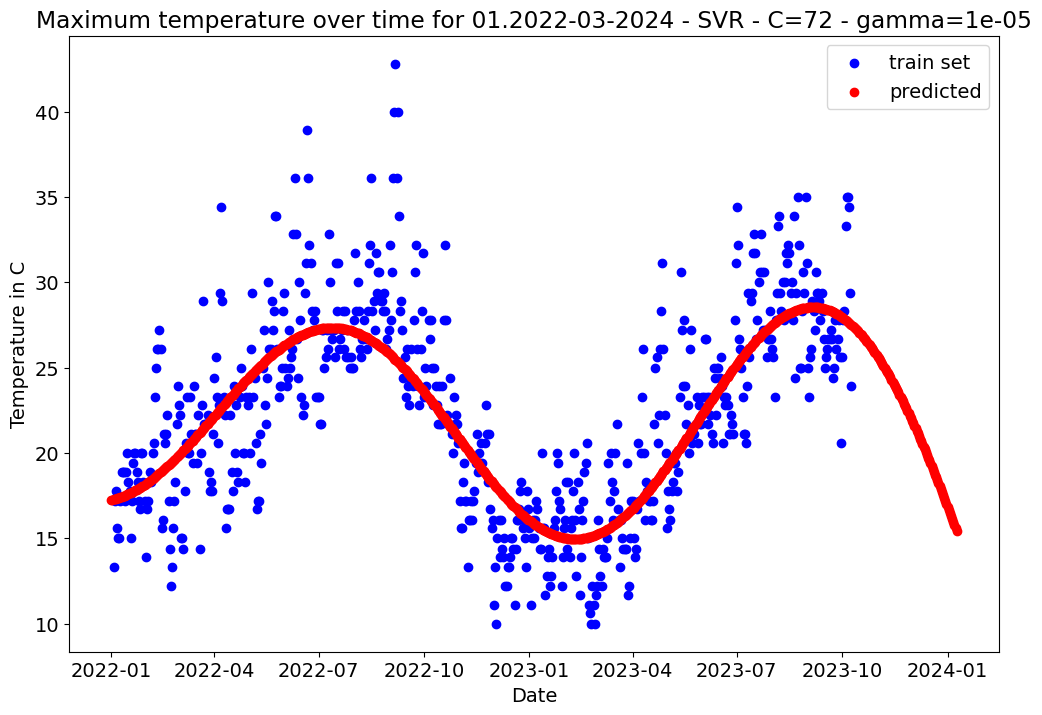

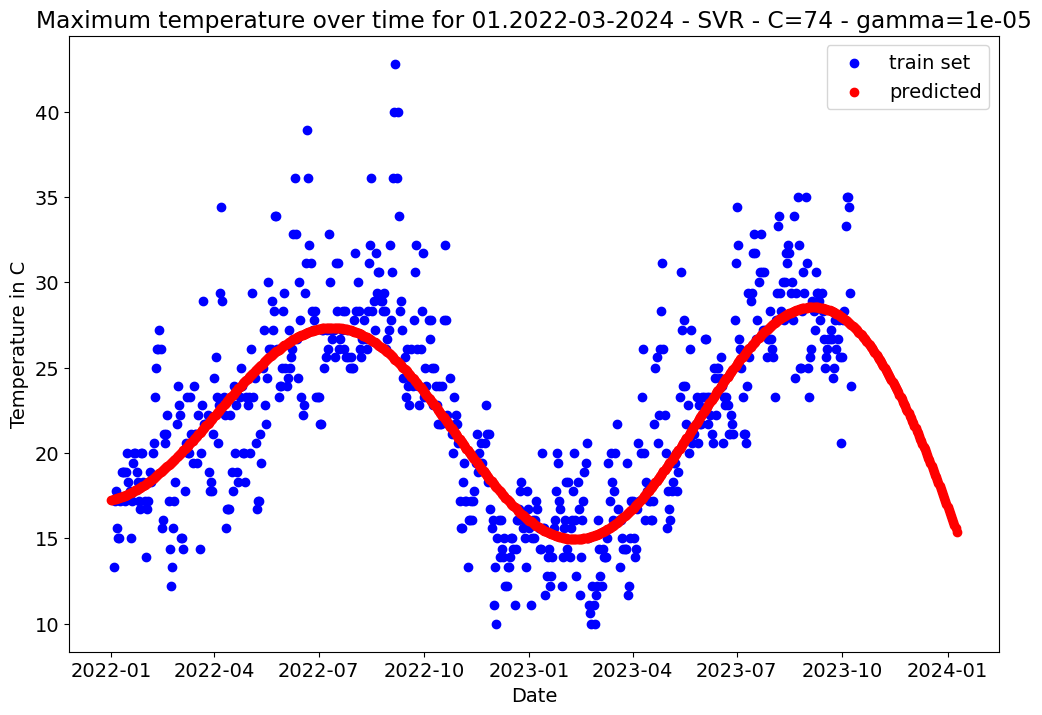

In [4]:
#Since the previous test showed good results for C=61 and most good results had gamma=0.00001
#Cycle through the nearest C-values to maybe find even better options
for j in range(60,76,2):
        svr_tmax=SVR(kernel='rbf', C=j, gamma=0.00001)

        svr_tmax.fit(tmax_X, tmax_y)

        tmax_pred=svr_tmax.predict(new)
            
        plt.title(f"Maximum temperature over time for 01.2022-03-2024 - SVR - C={j} - gamma={0.00001}")
        plt.scatter(tmax_X,tmax_y, color="blue")
        plt.scatter(new, tmax_pred, color="red")
        plt.xlabel("Date")
        plt.ylabel("Temperature in C")
        plt.legend(['train set','predicted'])
        plt.plot()
        plt.show()

Final pick: C= 64, gamma=0.00001  
Starting to work on TMIN

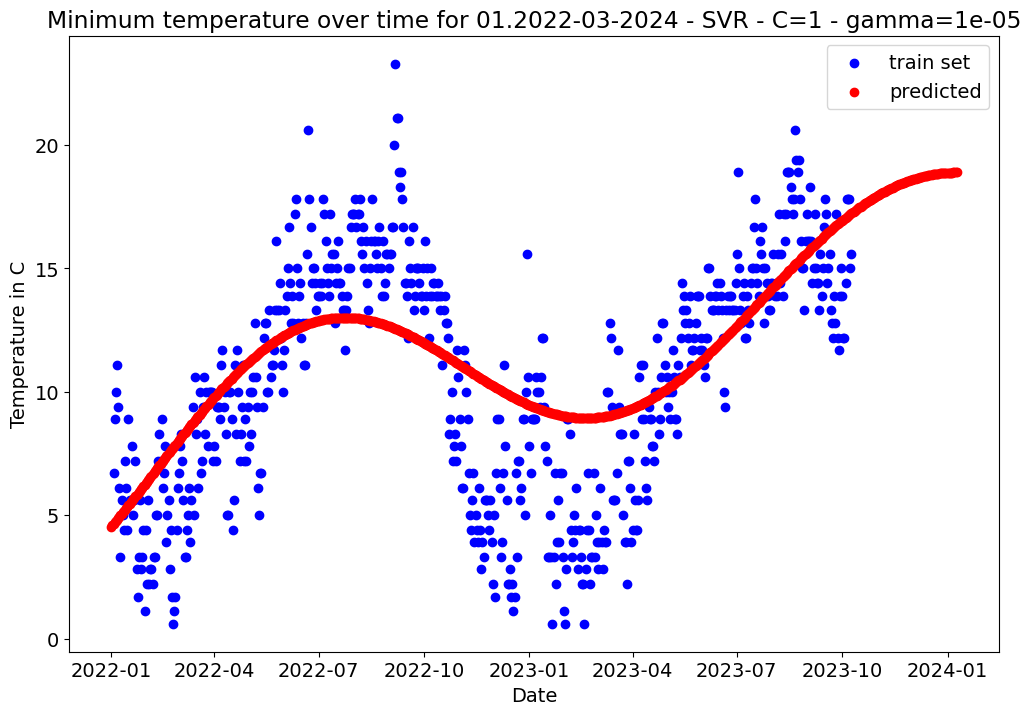

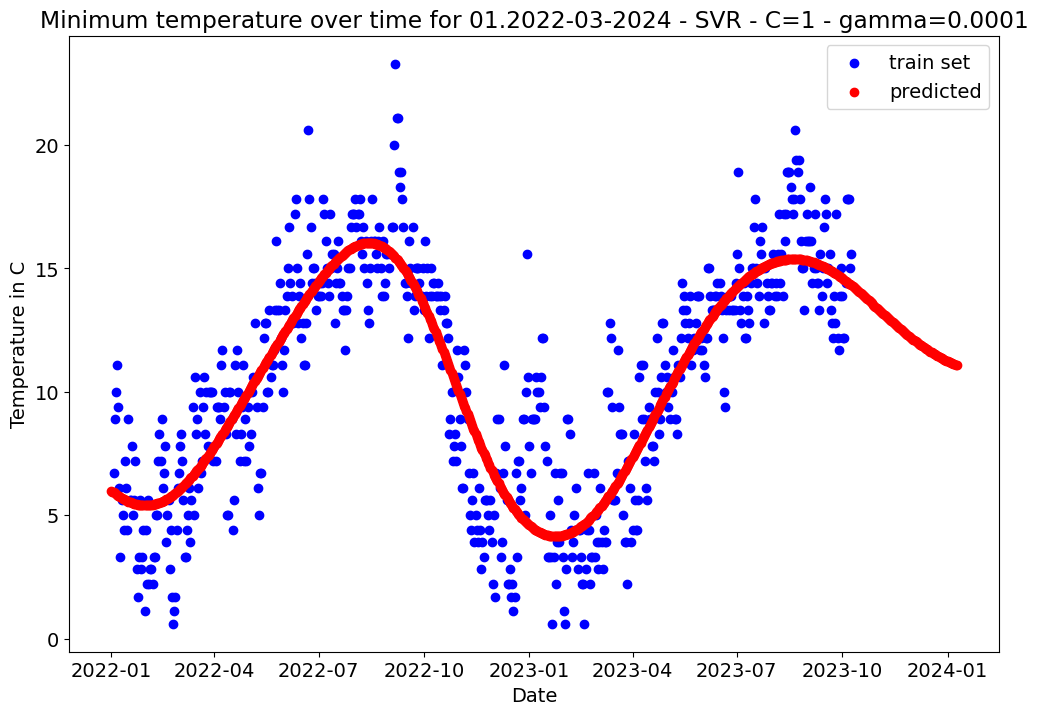

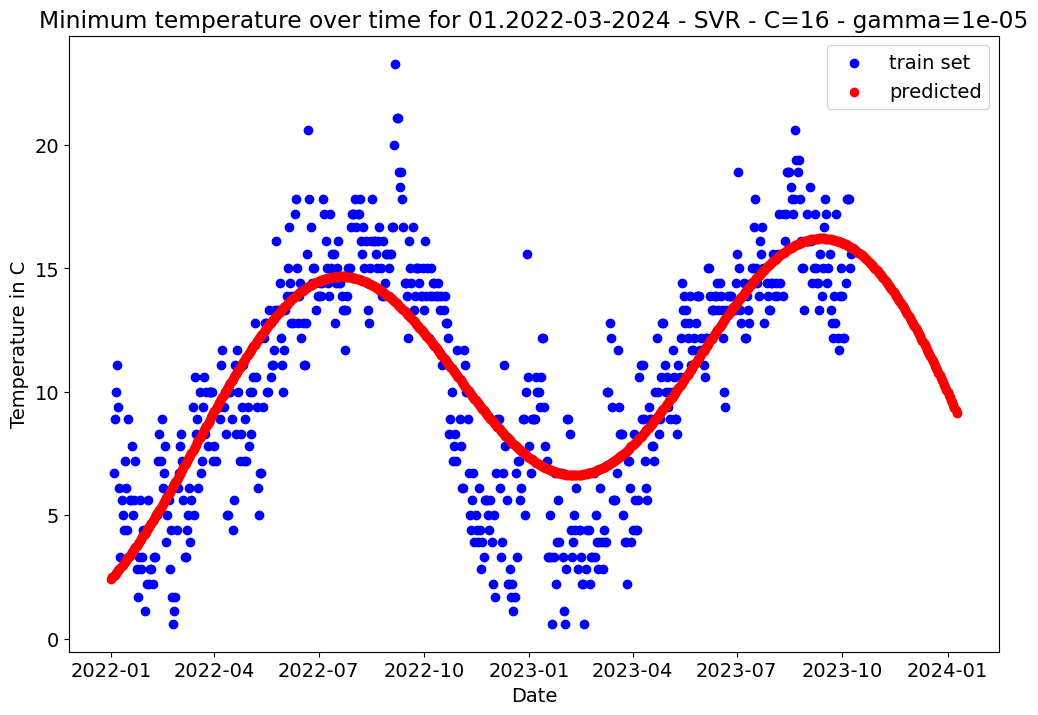

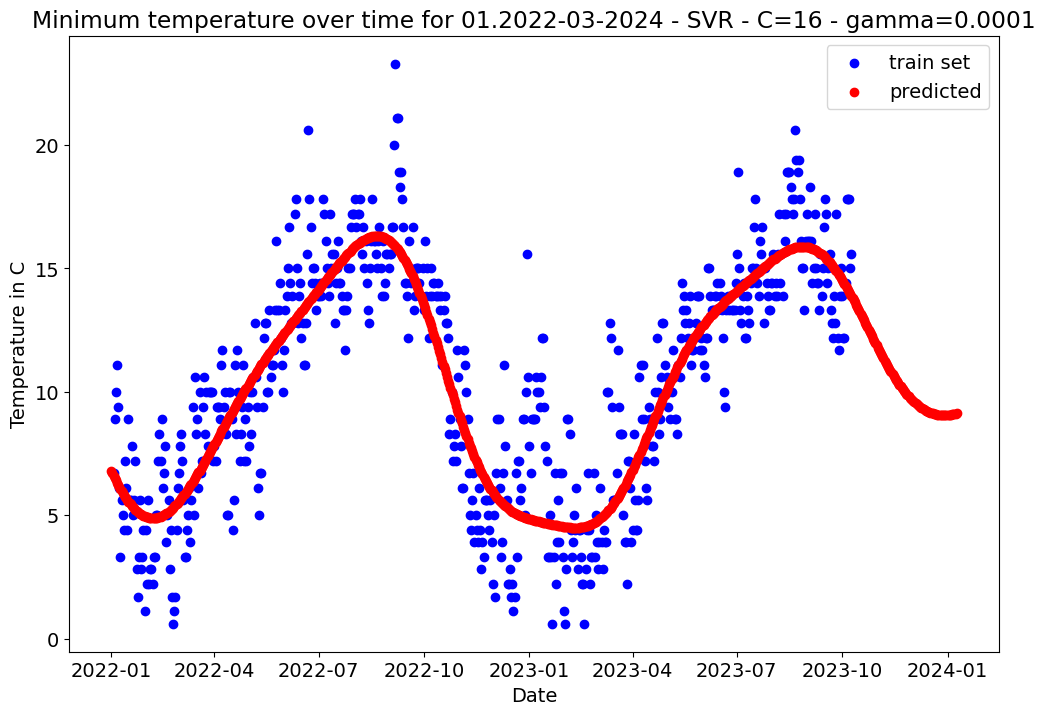

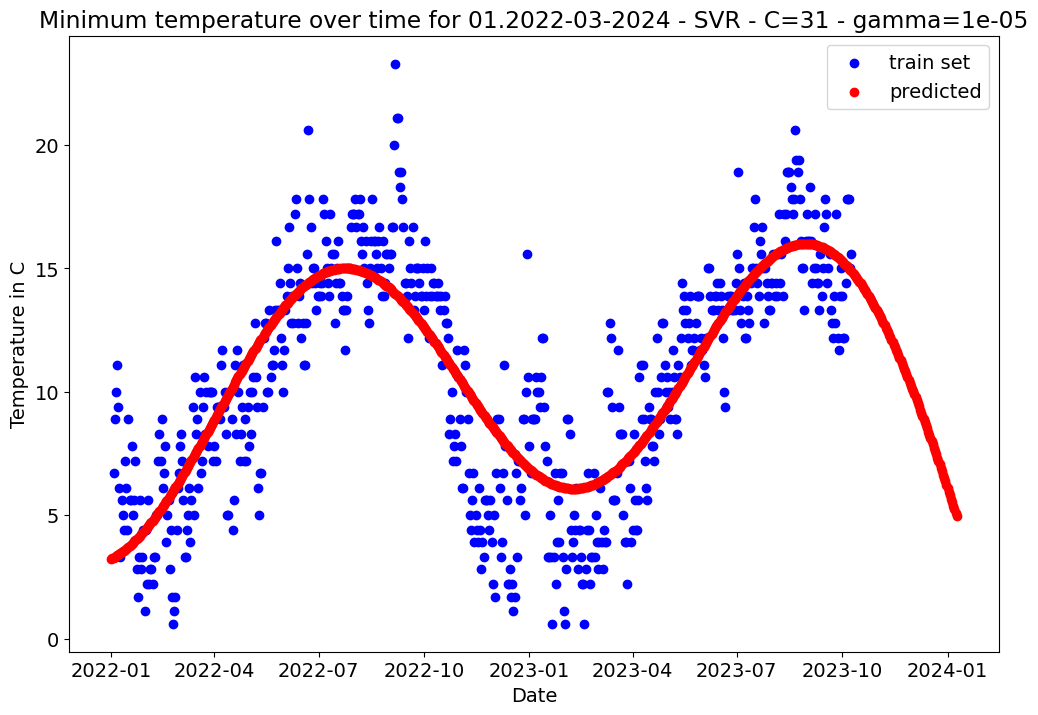

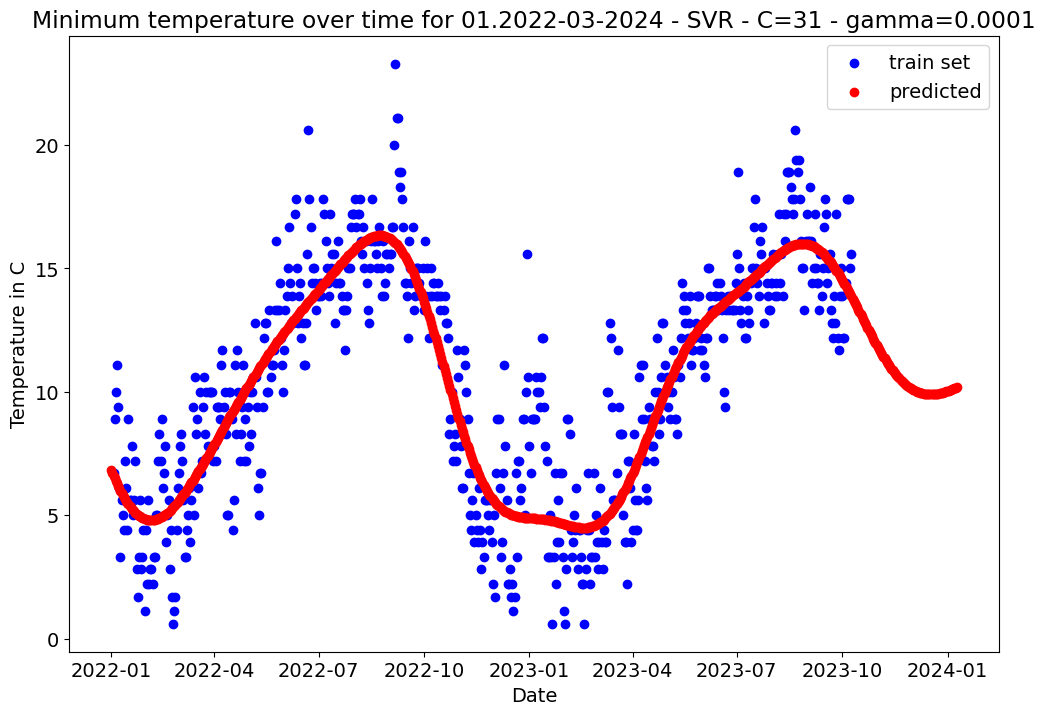

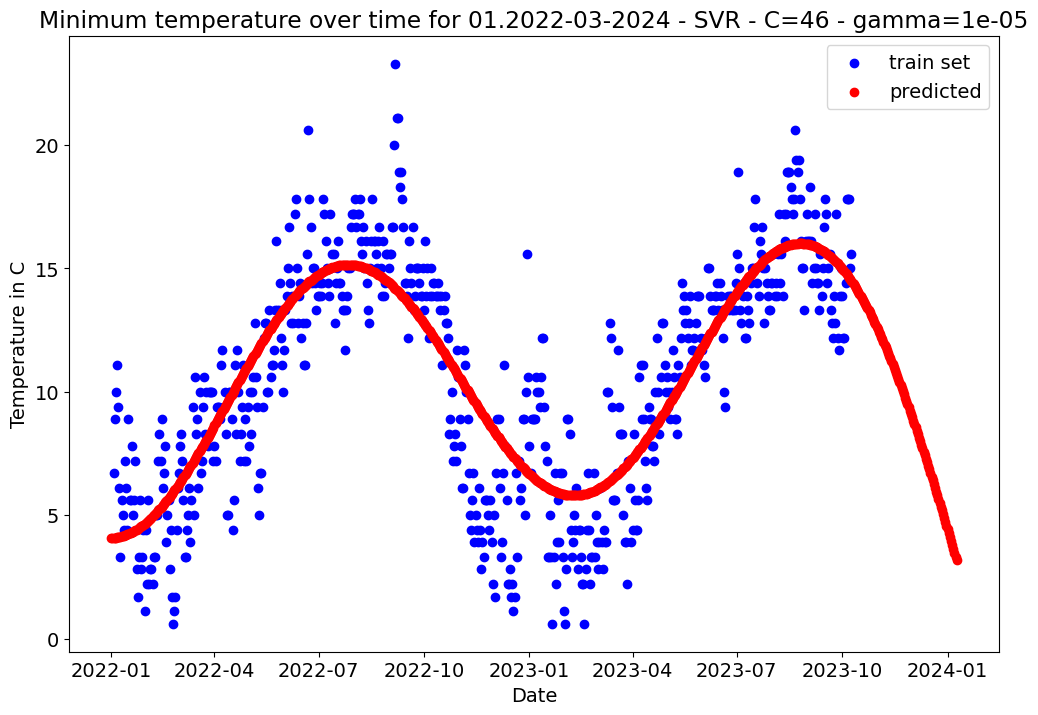

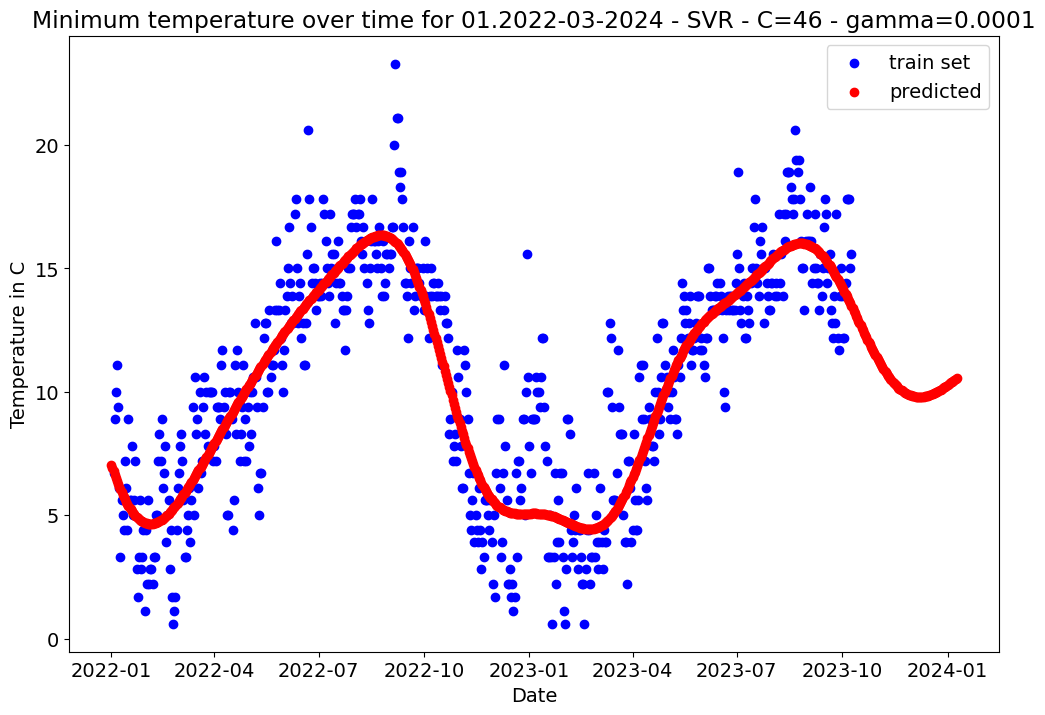

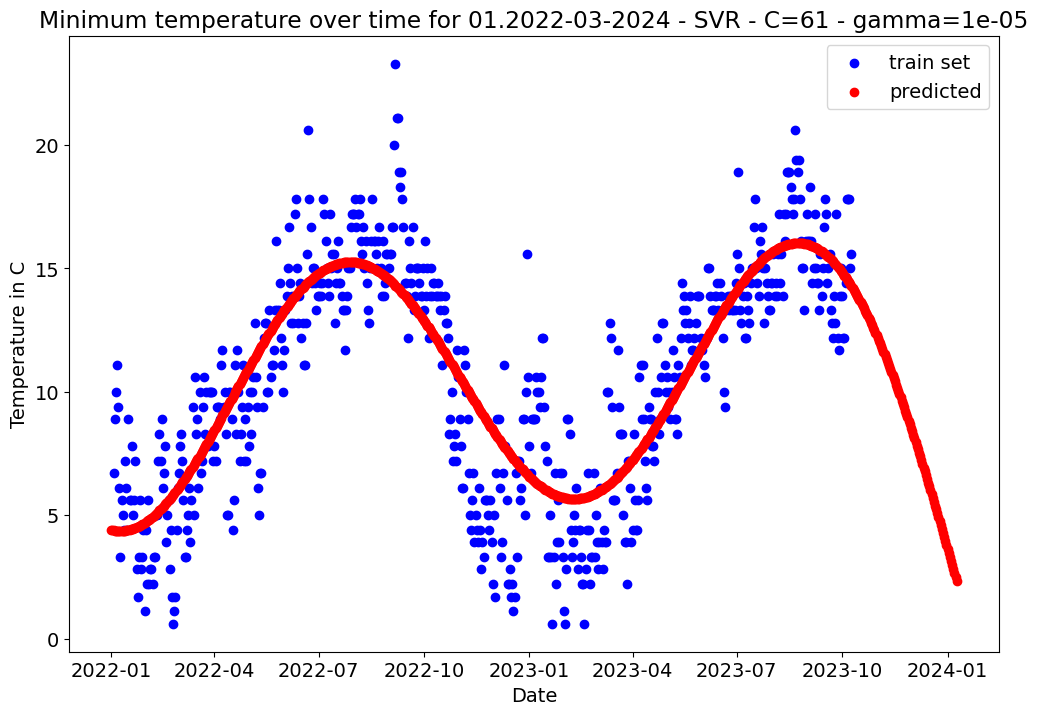

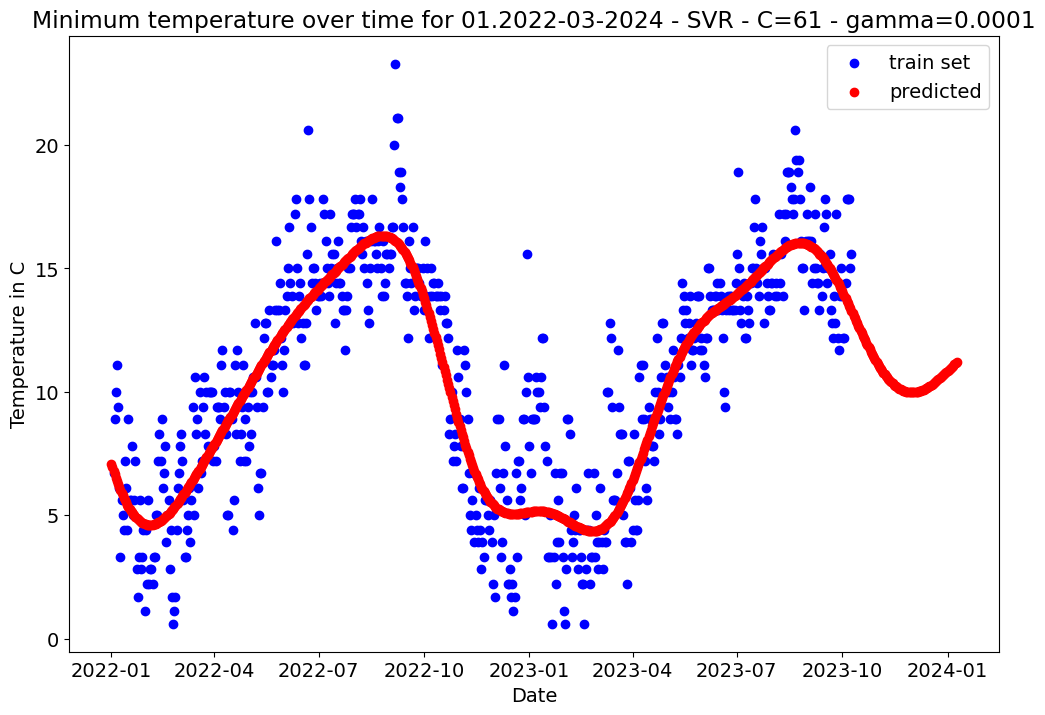

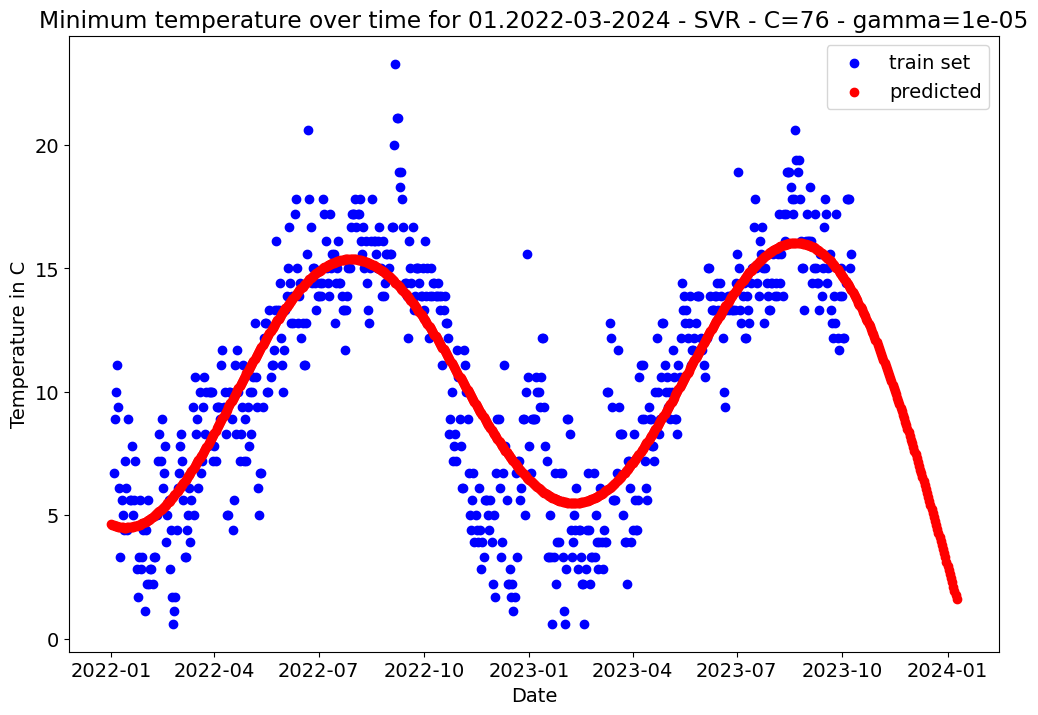

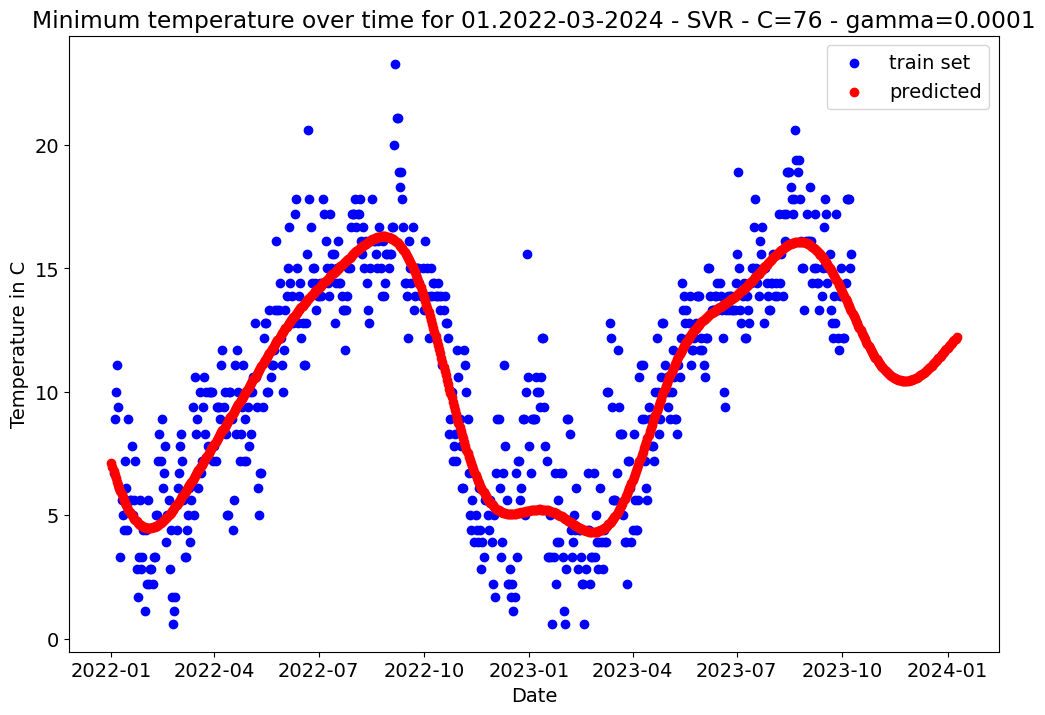

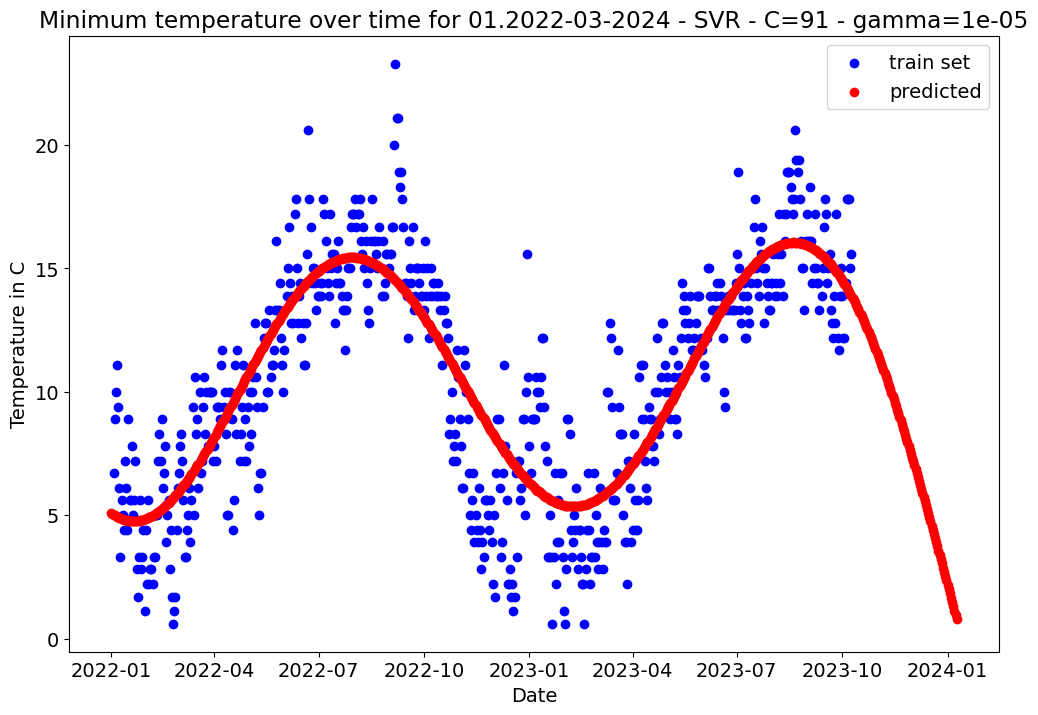

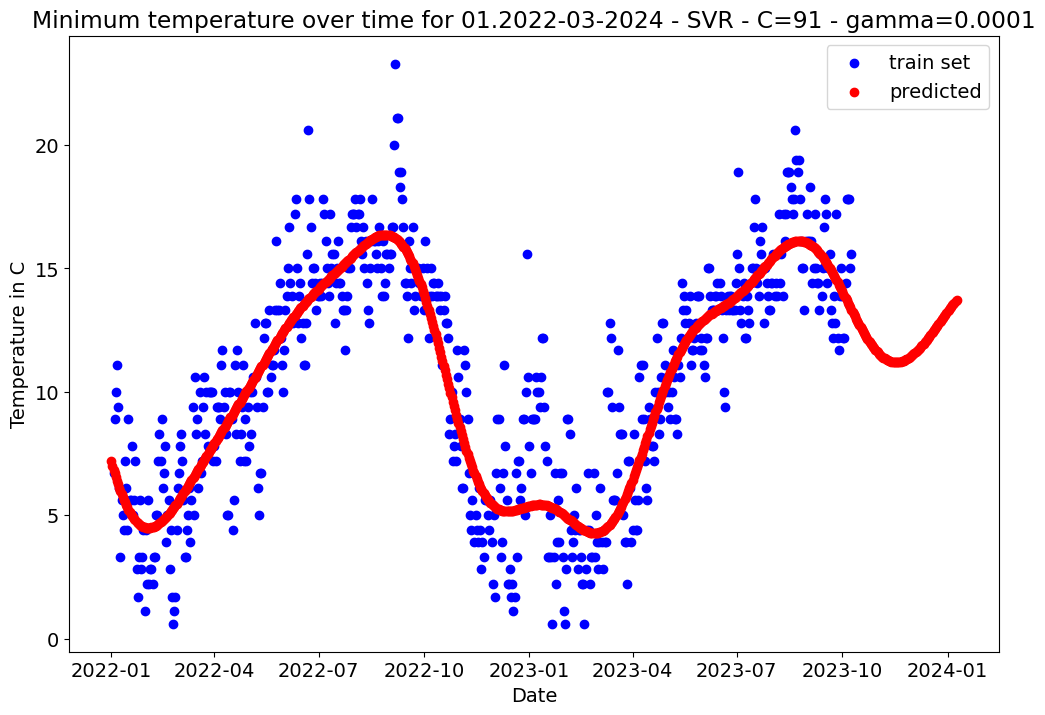

In [5]:
#Same preprocessing routine for TMIN
tmin_X=np.asarray(weather_df['DATE'].astype('string'))
tmin_y=np.asarray(weather_df['TMIN'])

for i in range(len(tmin_X)):
    tmin_X[i]=np.datetime64(tmin_X[i])
    
tmin_X=tmin_X.reshape(-1, 1)

g=[1.e-5, 1.e-4]

for j in range(1,101,15):

        for k in g:
            svr_tmin=SVR(kernel='rbf', C=j, gamma=k)

            svr_tmin.fit(tmin_X, tmin_y)

            tmin_pred=svr_tmin.predict(new)

            plt.title(f"Minimum temperature over time for 01.2022-03-2024 - SVR - C={j} - gamma={k}")
            plt.scatter(tmin_X,tmin_y, color="blue")
            plt.scatter(new, tmin_pred, color="red")
            plt.xlabel("Date")
            plt.ylabel("Temperature in C")
            plt.legend(['train set','predicted'])
            plt.plot()
            plt.show()

Somewhere around C=16 gamma=0.00001 looks good even with 4 months range.  
Taking a look closer to 15-31 interval.

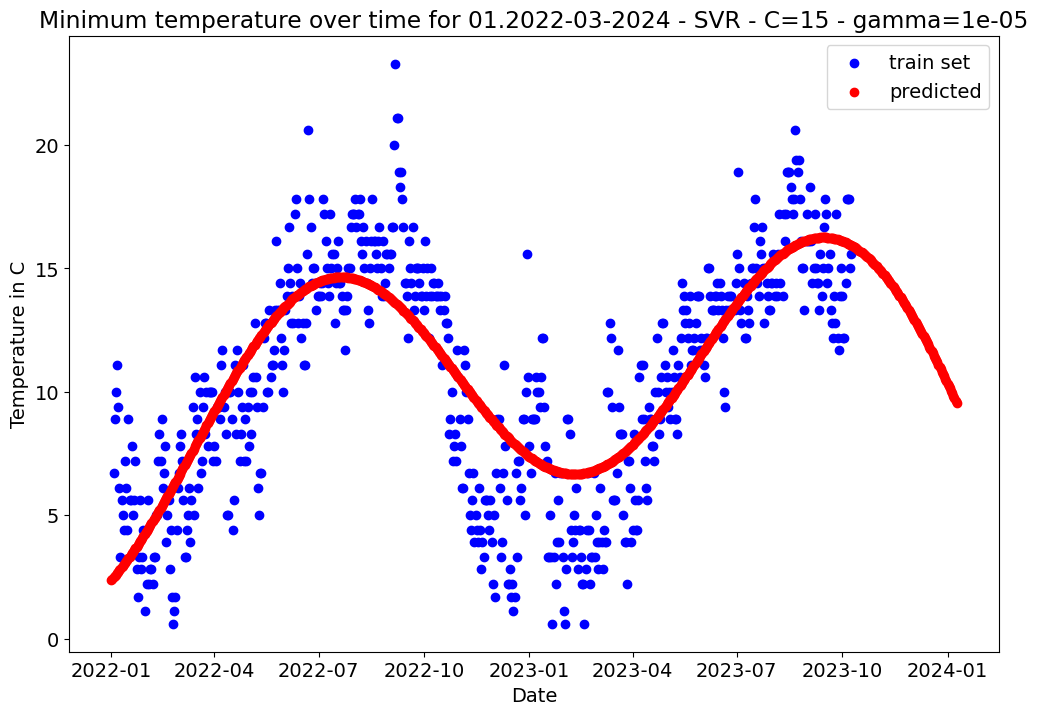

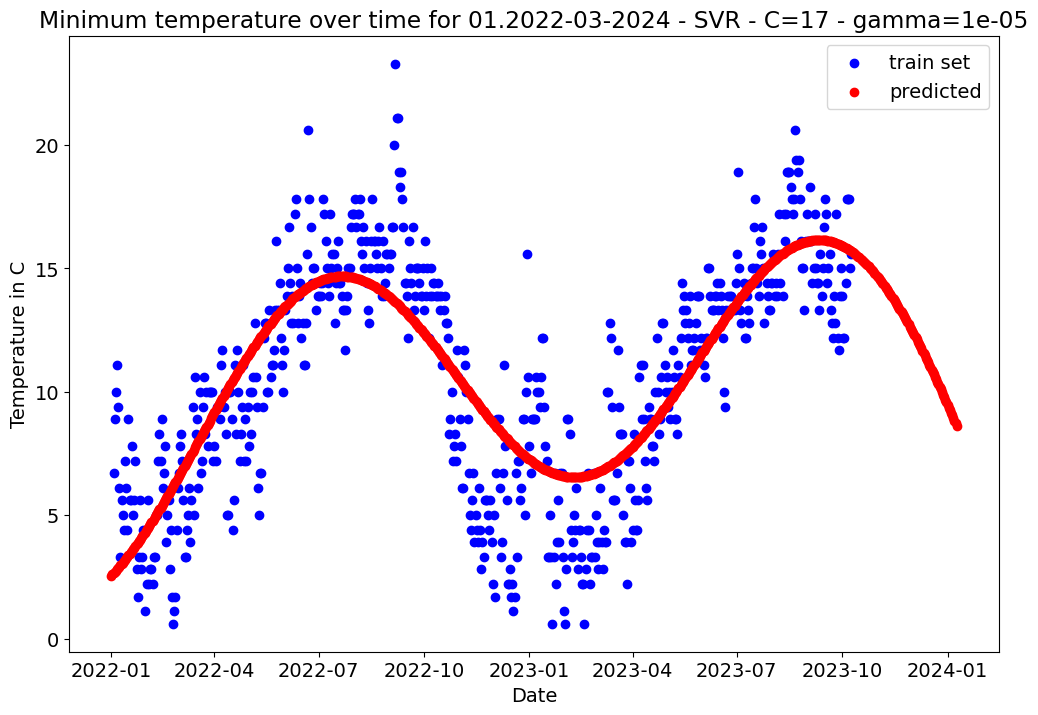

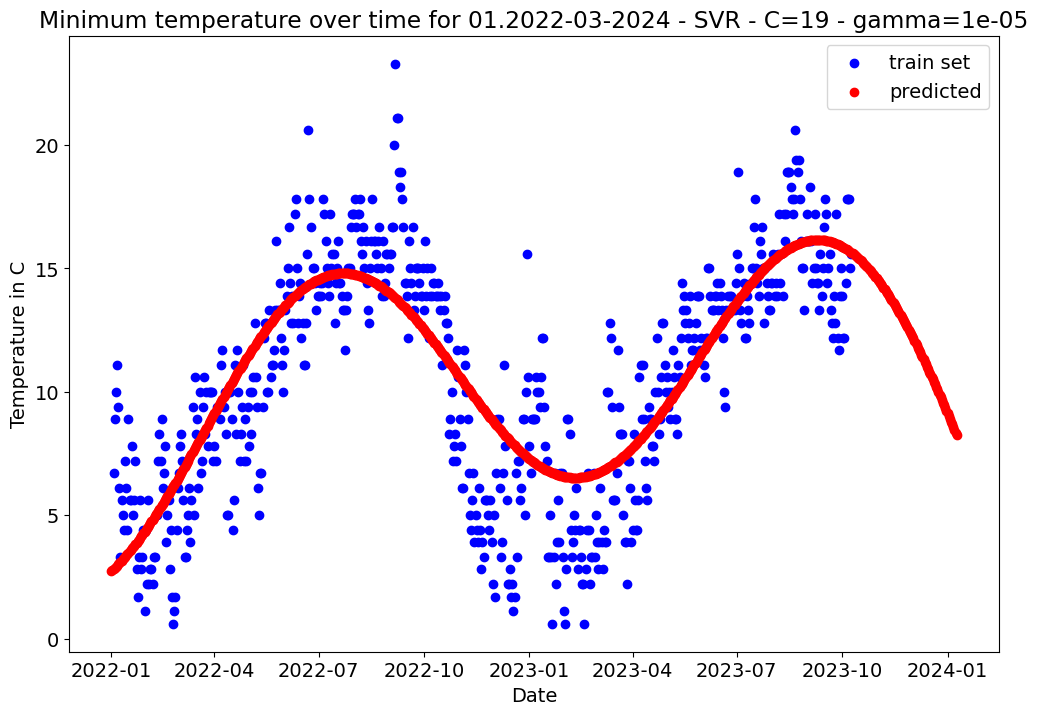

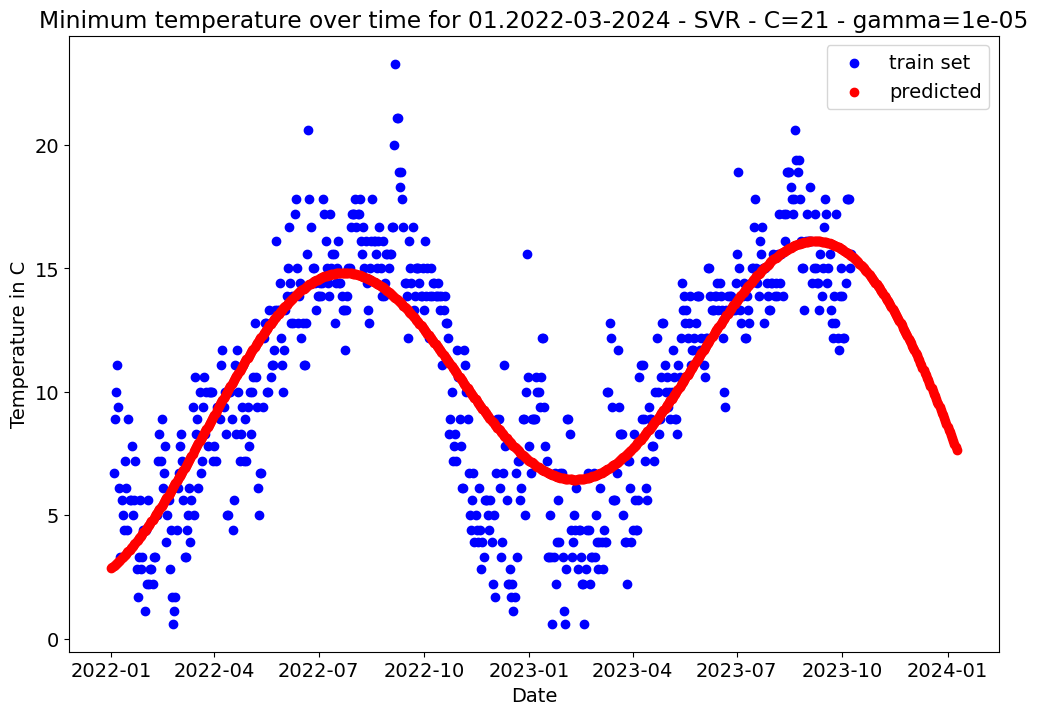

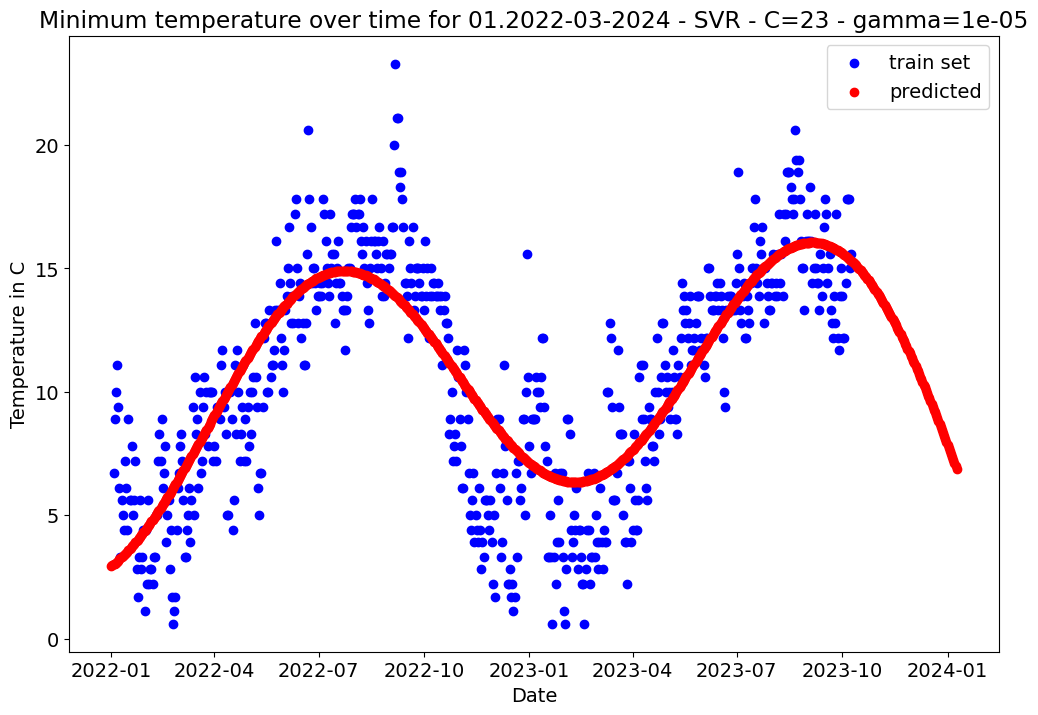

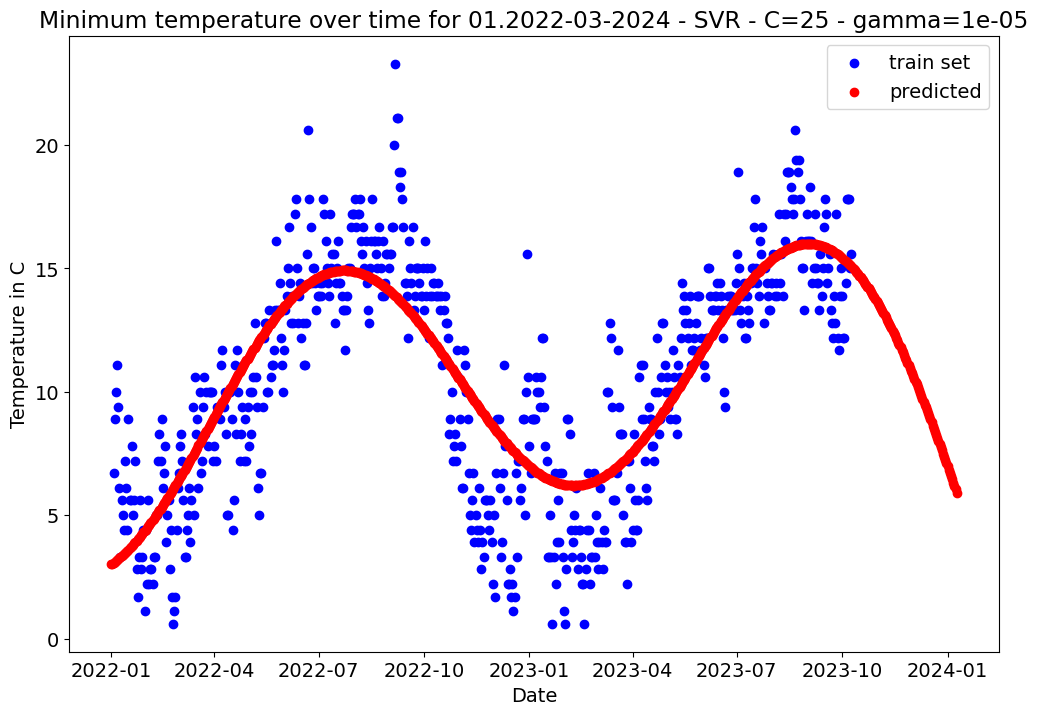

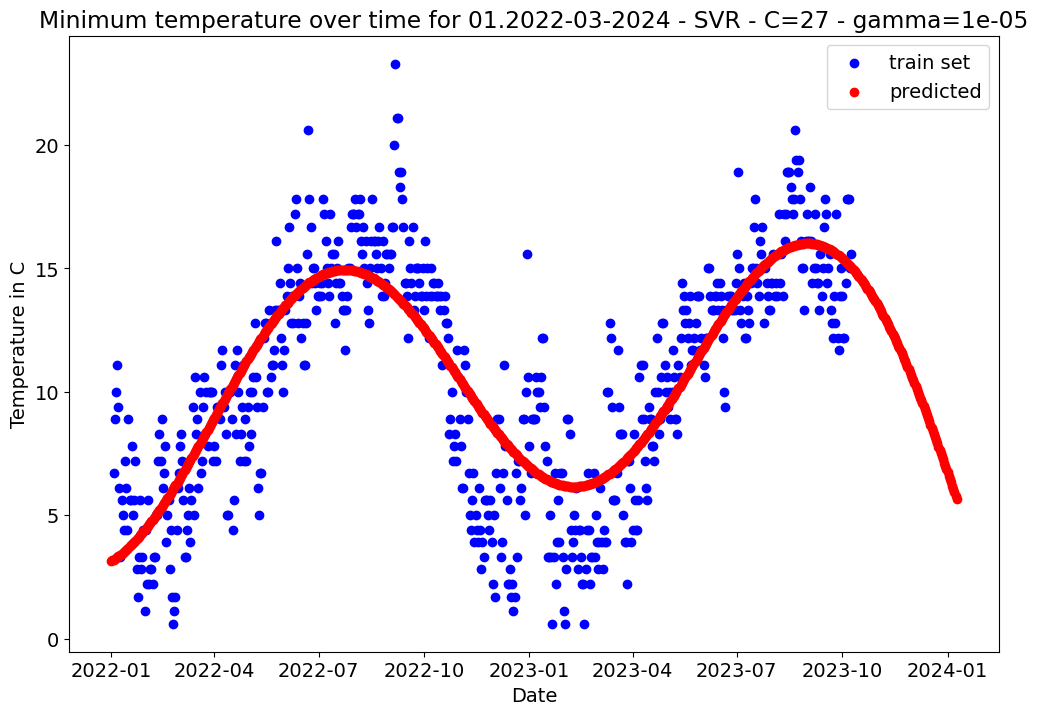

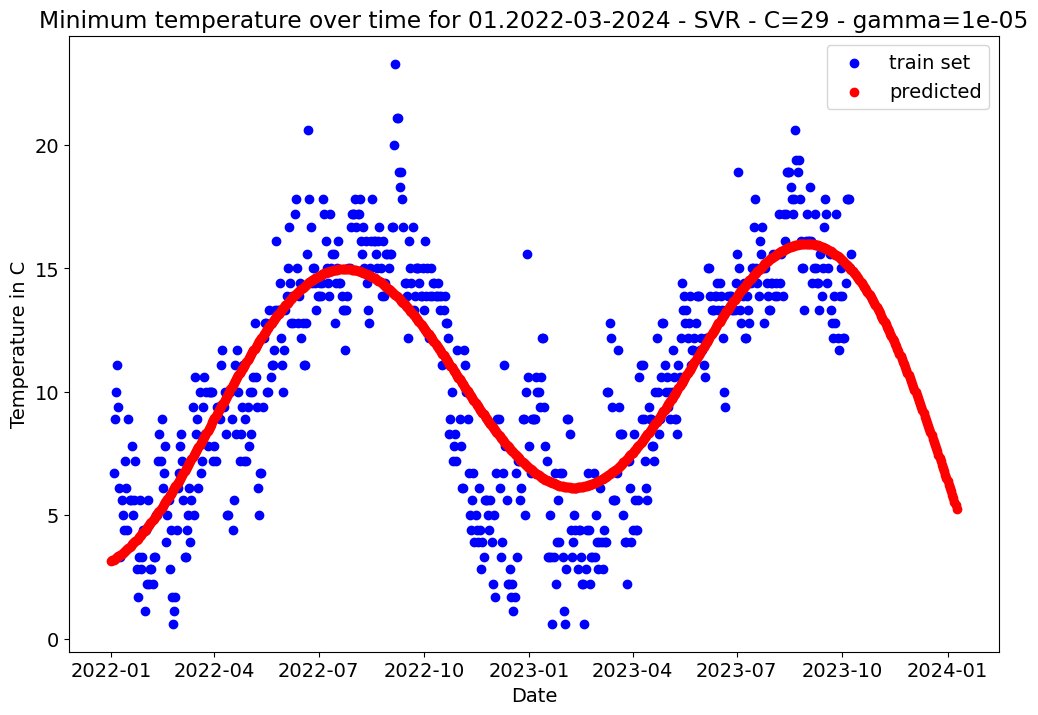

In [6]:
for j in range(15,31,2):
        svr_tmin=SVR(kernel='rbf', C=j, gamma=0.00001)

        svr_tmin.fit(tmin_X, tmin_y)

        tmin_pred=svr_tmin.predict(new)
            
        plt.title(f"Minimum temperature over time for 01.2022-03-2024 - SVR - C={j} - gamma={0.00001}")
        plt.scatter(tmin_X,tmin_y, color="blue")
        plt.scatter(new, tmin_pred, color="red")
        plt.xlabel("Date")
        plt.ylabel("Temperature in C")
        plt.legend(['train set','predicted'])
        plt.plot()
        plt.show()

C=25 with gamma=0.00001 looks best here too.  
Assembling the final result.

1 Final look at both picked models

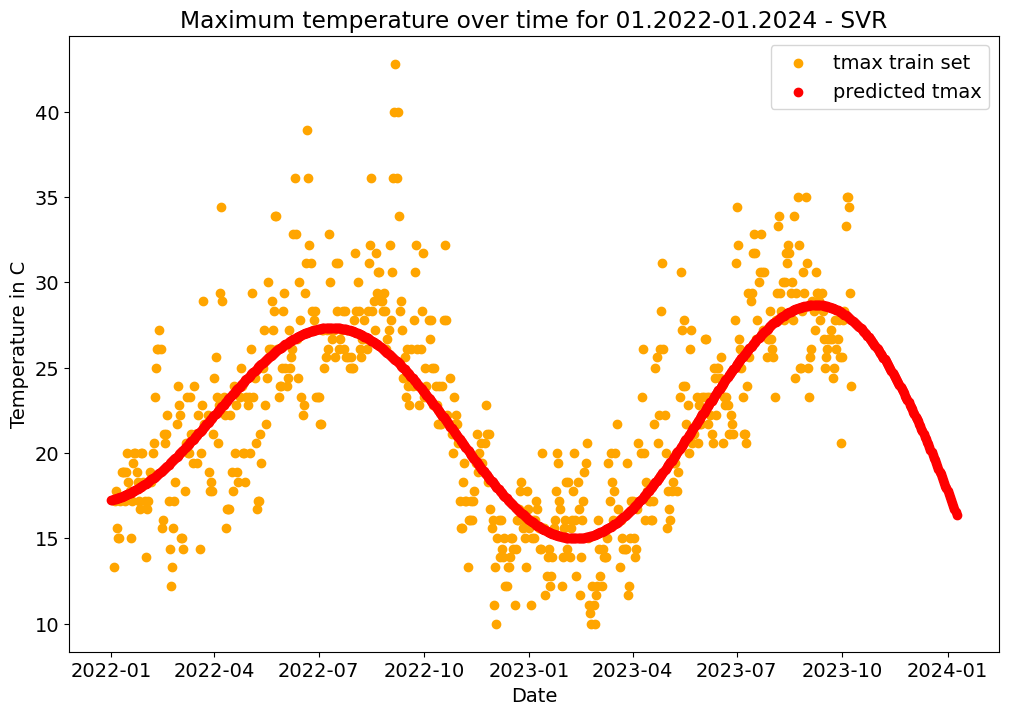

In [7]:
#Initializing the models with best hyperparameters
svr_tmax=SVR(kernel='rbf', C=64, gamma=0.00001)

svr_tmax.fit(tmax_X, tmax_y)

tmax_pred=svr_tmax.predict(new)

plt.title(f"Maximum temperature over time for 01.2022-01.2024 - SVR")

plt.scatter(tmax_X,tmax_y, color="orange")
plt.scatter(new, tmax_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.legend([ 'tmax train set','predicted tmax'])
plt.plot()
plt.show()

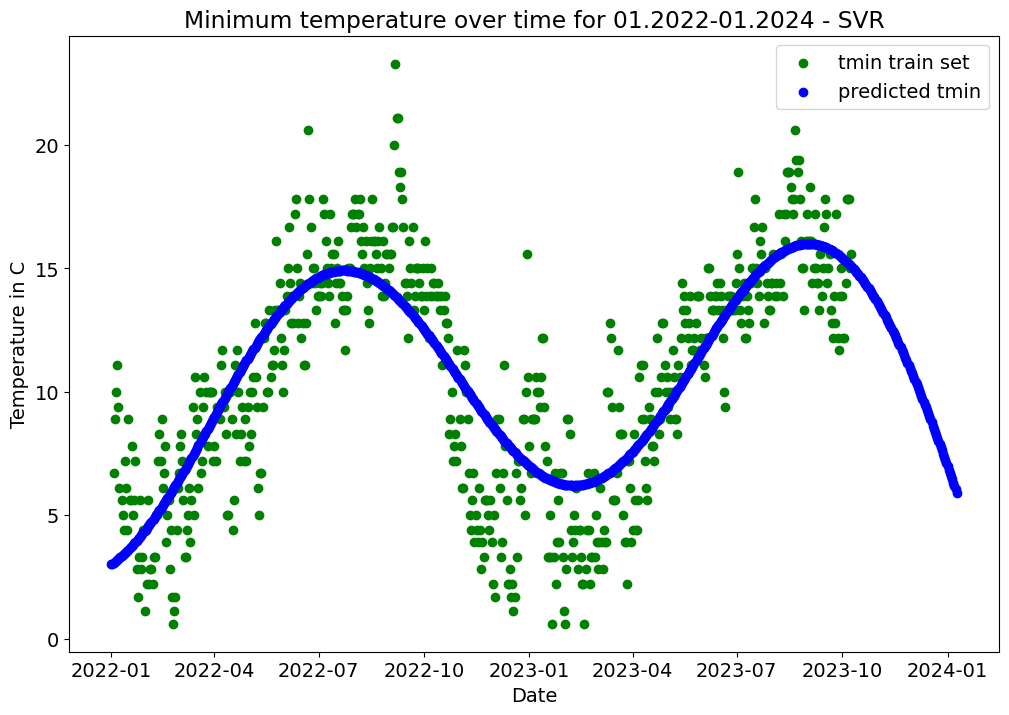

In [8]:
svr_tmin=SVR(kernel='rbf', C=25, gamma=0.00001)

svr_tmin.fit(tmin_X, tmin_y)

tmin_pred=svr_tmin.predict(new)


plt.title(f"Minimum temperature over time for 01.2022-01.2024 - SVR")
plt.scatter(tmin_X,tmin_y, color="green")
plt.scatter(new, tmin_pred, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.legend(['tmin train set','predicted tmin'])
plt.plot()
plt.show()

Combining the results:

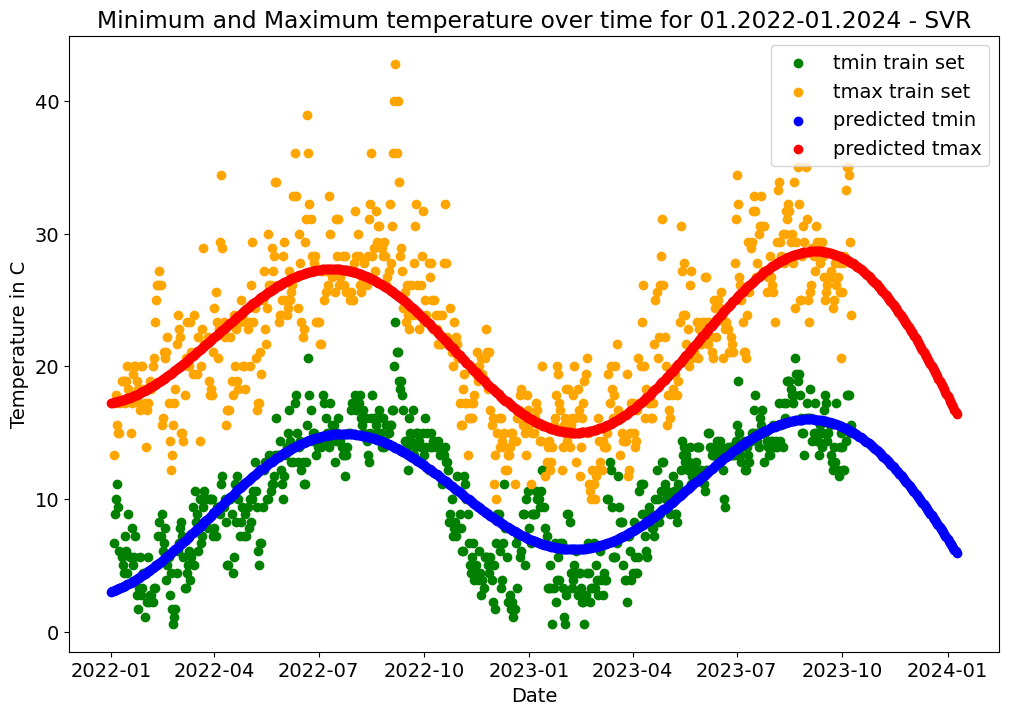

In [9]:
#Initializing the models with best hyperparameters
svr_tmax=SVR(kernel='rbf', C=64, gamma=0.00001)
svr_tmin=SVR(kernel='rbf', C=25, gamma=0.00001)

svr_tmax.fit(tmax_X, tmax_y)
svr_tmin.fit(tmin_X, tmin_y)

#predict for the smaller interval for consistency
tmin_pred=svr_tmin.predict(new)
tmax_pred=svr_tmax.predict(new)

plt.title(f"Minimum and Maximum temperature over time for 01.2022-01.2024 - SVR")
plt.scatter(tmin_X,tmin_y, color="green")
plt.scatter(tmax_X,tmax_y, color="orange")
plt.scatter(new, tmin_pred, color="blue")
plt.scatter(new, tmax_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.legend(['tmin train set', 'tmax train set','predicted tmin','predicted tmax'])
plt.plot()
plt.show()

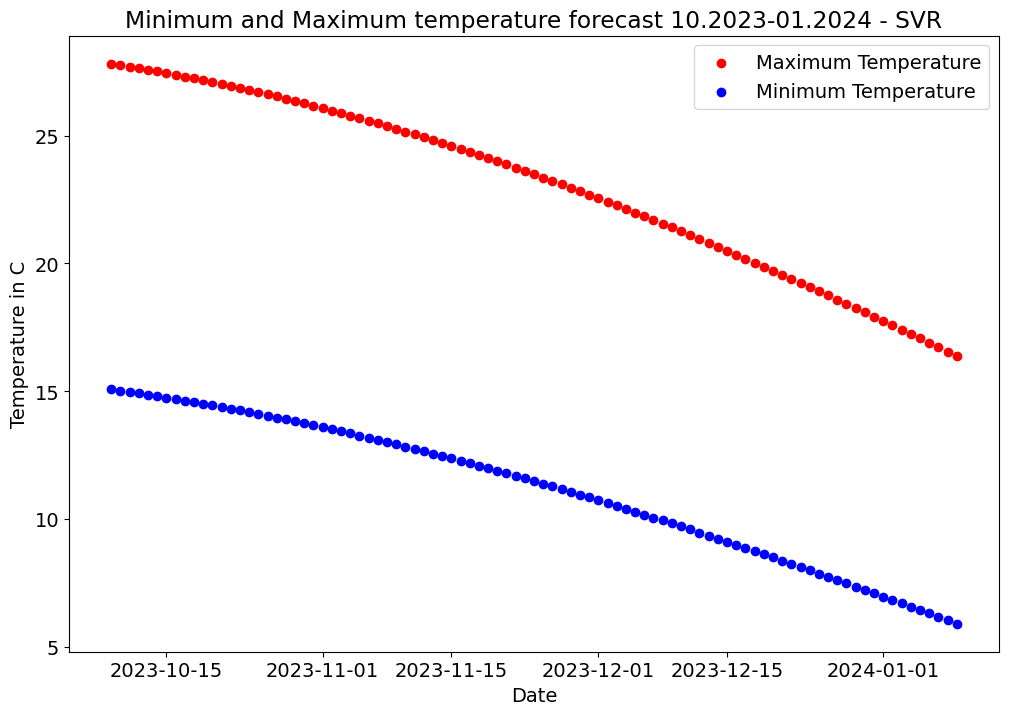

In [10]:
#New dates only
forecast = pd.date_range('2023-10-09','2024-01-09', freq='1D')
forecast=forecast.astype('string')

forecast=np.asarray(forecast)

for i in range(len(forecast)):
        forecast[i]=np.datetime64(forecast[i])

forecast=forecast.reshape(-1, 1)

tmin_forecast=svr_tmin.predict(forecast)
tmax_forecast=svr_tmax.predict(forecast)

plt.title(f"Minimum and Maximum temperature forecast 10.2023-01.2024 - SVR")
plt.scatter(forecast, tmax_forecast, color="red")
plt.scatter(forecast, tmin_forecast, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.legend(['Maximum Temperature','Minimum Temperature'])
plt.plot()
plt.show()

In [11]:
#On the day of presentation the model predicted:
a='2023-11-28'
a=np.datetime64(a)
a=a.reshape(-1, 1)
print(svr_tmax.predict(a))
print(svr_tmin.predict(a))

[22.96212866]
[11.07055721]


22.96 max temperature and 11.07 min temperature

In [12]:
#Today's forecast
a='2023-11-16'
a=np.datetime64(a)
a=a.reshape(-1, 1)
print(svr_tmax.predict(a))
print(svr_tmin.predict(a))

[24.47812208]
[12.28932638]


11/16's actually had 13 degrees minimum during the night, 12 is close  
22 max, 24 is close

In [13]:
#Additional dates test
a='2023-12-16'
a=np.datetime64(a)
a=a.reshape(-1, 1)
print(svr_tmax.predict(a))
print(svr_tmin.predict(a))

[20.34861741]
[9.00271519]


In [14]:
#Additional dates test
a='2024-01-05'
a=np.datetime64(a)
a=a.reshape(-1, 1)
print(svr_tmax.predict(a))
print(svr_tmin.predict(a))

[17.07249697]
[6.45105245]
